# Predictive analysis of BoligPortal data

In this notebook, we import the already clean and nicely formatted data on accommodations listed on the BoligPortal website and use tools such as statistical analysis (including regression modelling) and machine learning in order to predict rent size based on a number of different accommodation characteristics (e.g. type of accommodation, number of rooms, location).

The focus in this notebook is on building a predictive model with a general good performance, rather than on getting an understanding of which factors are correlated with rent prices. In here, we're not necessarily driven by any hypotheses, we just want to extract the maximum amount of information out of the data we have so we can construct a model that can predict rent prices with a high degree of accuracy.

## User input for the analysis

In [1]:
"""
====================
Providing user input
====================
"""

# Defining file storage location: either "Drive" or "Local"
FileStorageForUse = "Drive"

# If using Google Drive, specify project folder
ProjectFolder = "Projects/IT/BoligPortal insights/"

## Setting things up

We start out by importing all relevant packages for our work and by defining some custom functions that will help us extract the data that we need.

In [2]:
import datetime as dt
Today = dt.date.today()
print("This notebook was last updated on:", Today)
print("Author: Kiril Boyanov (kirilboyanovbg@gmail.com)")
print("Connect on LinkedIn: https://www.linkedin.com/in/kirilboyanov/")

This notebook was last updated on: 2023-02-22
Author: Kiril Boyanov (kirilboyanovbg@gmail.com)
Connect on LinkedIn: https://www.linkedin.com/in/kirilboyanov/


In [3]:
%%capture
# Installing packages that may not always be available
# This is mostly relevant for Google Colab
# No special needs as of 01-11-2022

In [54]:
# Importing relevant packages
import pandas as pd
import pandas.tseries.offsets as offset
from pandas.api.types import is_numeric_dtype
import datetime as dt
import numpy as np

# Specifically used for data visualisation
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec

# Specifically used for regression analysis
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Setting custom chart size & related other properties
# sns.set(rc = {"figure.figsize":(4, 3)})
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300

# Setting custom theme for  plots
DefaultColormapQual = "Set2"
sns.color_palette("Set2", as_cmap = True)
ColorPalette = sns.color_palette("Set2")
ColorPalette.as_hex()

# Setting custom limits for maximum N of rows/cols to print in data previews
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Specifically used for random forest models/machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
import math

# Random state numbers to be used for ensuring reproducibility of results
# The specific numbers provided by the user don't matter much, I've kept them different just to be on the safe side
RandomStateNumberDataSplit = 50 # for splitting the data into a training set & a test set
RandomStateNumberModels = 50 # for running the random forest models

In [5]:
"""
=======================================
Arranging data storage for the analysis
=======================================
"""

# Creating a universal folder reference to use regardless of chosen storage method
if FileStorageForUse == "Local":
  import os
  AnalysisFolder = os.getcwd() + "/"
  print("The analysis will be run using local data storage.")
  print("The data will be saved in the following directory:")
  print(AnalysisFolder)
elif FileStorageForUse == "Drive":
  from google.colab import drive
  drive.mount('/content/gdrive/', force_remount = True)
  AnalysisFolder = "/content/gdrive/MyDrive/" + ProjectFolder
  print("The analysis will be run using Google Drive for data storage.")
  print("The data will be saved in the following directory:")
  print(AnalysisFolder)
else:
  print("Incorrect output, please check the '' input before proceeding.")

Mounted at /content/gdrive/
The analysis will be run using Google Drive for data storage.
The data will be saved in the following directory:
/content/gdrive/MyDrive/Projects/IT/BoligPortal insights/


In [6]:
"""
=======================================================
Custom function that plots data labels on seaborn plots
=======================================================
"""

def show_values_on_bars(axs, fontsize = 8):
    
    from matplotlib import pyplot as plt
    import numpy as np
    
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", fontsize = fontsize) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [7]:
"""
===================================================
Custom function to plot actual vs. predicted values
===================================================
"""

def ActualVsPredictedPlot(ActualSeries, PredictedSeries):
    """
    This function takes two series representing the actual values of a certain variable
    and its predicted values from an associated regression model and plots them against
    one another alongside a 45 degree line which would represent a perfect fit.

    **Actual series**: a Series object containing the actual values of the variable.
    **Predicted series**: a Series object containing the predicted values of the variable.
    """
    from matplotlib import pyplot as plt
    
    p1 = max(max(PredictedSeries), max(ActualSeries))
    p2 = min(min(PredictedSeries), min(ActualSeries))
    PlotActual = plt.plot([p1, p2], [p1, p2], "b-", color = "#4099DA")
    PlotActual = plt.scatter(x = ActualSeries, y = PredictedSeries, color = "#8CC2E9")
    PlotActual = plt.xlabel("Actual value")
    PlotActual = plt.ylabel("Predicted value")
    PlotActual = plt.axis("equal")
    #PlotActual = plt.title("Actual vs. predicted time-to-hire values based on the model")
    
    return PlotActual

In [8]:
"""
====================================================
Function used to plot residuals vs. predicted values
====================================================
"""

def ResidualVsPredictedPlot(Model, DataSource, PredictedSeries, Standardised, Y_Var_String):
    """
    This function takes two series representing the predicted value of a certain variable
    and its residuals from an associated regression model and plots them against
    one another alongside a constant line at the zero level which would represent a perfect fit. 
    The function computes the residual values on its own based on the provided data source but
    obtains the predicted (fitted) values from a user-specified model.
    
    **Model**: a regression model to use for estimating the residuals.
    **DataSource**: a DataFrame object used to store the residuals.
    **Predicted series**: a Series object containing the predicted values of the variable.
    **Standardised**: indicates whether to plot the simple or the standardised residuals (True/False).
    **Y_Var_String**: a string representing the name of the variable we're doing the prediction for.
    """
    from matplotlib import pyplot as plt
    
    DataSource["Residuals"] = Model.resid
    DataSource["StandardisedResiduals"] = DataSource["Residuals"]/np.std(DataSource["Residuals"])

    if Standardised == True:
        ResidualsToUse = DataSource["StandardisedResiduals"]
        PlotTitle = "Standardized residuals vs. predicted " + Y_Var_String
    else:
        ResidualsToUse = DataSource["Residuals"]
        PlotTitle = "Residuals vs. predicted " + Y_Var_String

    p1 = max(max(ResidualsToUse), max(PredictedSeries))
    p2 = min(min(ResidualsToUse), min(PredictedSeries))
    PlotResiduals = plt.scatter(x = PredictedSeries, y = ResidualsToUse, color = "#8CC2E9")
    plt.axhline(y = 0, color = "#4099DA", linestyle = "-")
    PlotResiduals = plt.xlabel("Predicted " + Y_Var_String, fontsize = 7)
    PlotResiduals = plt.ylabel("Residuals", fontsize = 7)
    PlotActual = plt.xticks(fontsize = 6)
    PlotActual = plt.yticks(fontsize = 6)
    PlotResiduals = plt.title(PlotTitle, fontsize = 8)
    
    return PlotResiduals

In [9]:
"""
===========================================================
Custom function to create relevant plots for model fit eval
===========================================================
"""

def GenModelFitPlots(Predictions, Actuals, Y_String):

  """
  This function creates a 3 by 1 grid with two histograms showing the distribution
  of both the actual and the predicted values of Y plus a scatter plot with both
  the actual and predicted values. These plots can be used in the process of
  evaluating model fit.

  **Predictions**: a pandas series object that contains the predicted values
  from a specific model.
  **Actuals**: a pandas series object that contains the actual values of Y.
  **Y_String**: a string that can be used to describe what Y measures (used to
  generate automatic titles for the plots so that they're a bit more user-friendly).
  """

  # Creating 3 side-by-side plots
  fig, axes = plt.subplots(1, 3, figsize = (12, 4))

  # Plotting histograms of the observed outcome and the predicted values
  sns.histplot(x = Actuals, ax = axes[0], bins = 10)
  sns.histplot(x = Predictions, ax = axes[1], bins = 10)

  # Customizing the titles displayed on the plot
  axes[0].title.set_text("Actual " + Y_String)
  axes[1].title.set_text("Predicted " + Y_String)
  axes[2].title.set_text("Actual vs. predicted plot")

  # Plotting actual vs. predicted values
  ActualVsPredictedPlot(Actuals, Predictions)
  plt.show()

In [10]:
"""
====================================================================
Custom funtion to fit an OLS model, generate model summary and plots
====================================================================
"""

def FitRegressionModel(ModelString, InputData):

  """
  This function tests a regression model defined as a string in R-like fashion
  and then prints both a summary of the key statistics related to the model and
  two kinds of plots (actual vs. predicted and actual vs. residuals) designed
  to help the user test and evaluate model fit. Please note that this function
  fits a heteroskedasticity-robust model.

  **ModelString**: model string showing the outcome and predicted variables,
  formatted in R-like fashion (i.e. "Y_Var ~ X_Var1 (+ X_Var2)").
  **InputData**: a pandas dataframe containing the variables included in the
  model which we would like to test.
  """

  # 0) Converting function inputs into usable parameters
  OutcomeVar = ModelString.split(" ~")[0]
  PredictorVars = ModelString.split(" ~")[1]
  PredictorVars = PredictorVars.replace(" ", "")
  PredictorVars = PredictorVars.split("+")

  # 1) Fitting a model
  DataForAnalysis = InputData.copy()
  RegressionModel = ModelString
  Model = smf.ols(formula = RegressionModel, data = DataForAnalysis).fit(cov_type = "HC1")
  print("===================================================")
  print("Testing OLS model with the following specification:")
  print("===================================================")
  print(RegressionModel, "\n")

  # 2) Printing model summary data
  print(Model.summary(), "\n")

  # 3) Generating predictions and plots
  # Predicting the outcome variable
  DataForAnalysis["PredictedValue"] = Model.predict(DataForAnalysis[PredictorVars])

  # Creating a grid with 1 row and 2 columns
  gs = gridspec.GridSpec(1, 2) 
  fig = plt.figure(figsize = (7, 3))

  # Plotting the actual vs. predicted values on the left hand side
  ax1 = plt.subplot(gs[0, 0])
  ax1 = ActualVsPredictedPlot(Model, DataForAnalysis["PredictedValue"], DataForAnalysis[OutcomeVar], OutcomeVar)

  # Plotting the residuals vs. predicted values on the right hand side
  ax2 = plt.subplot(gs[0, 1])
  ax2 = ResidualVsPredictedPlot(Model, DataForAnalysis, DataForAnalysis["PredictedValue"], True, OutcomeVar)

In [11]:
"""
===================================================================
Custom function to print model fit metrics for random forest models
===================================================================
"""

def ModelFitStats(ModelName, Outcome, Prediction, NumberOfDecimals = 2):
    """
    This function prints out useful summary metrics related to random forest models
    with an emphasis on both explanatory power (R-squared, MAE & MSE) and the distribution
    of the observed outcome vs. predicted variables (mean, standard deviation, etc.)
    
    **ModelName**: the object that contains the random forest model.
    **Outcome**: series containing the observed outcome variable.
    **Prediction**: series containing the outcome variable as predicted by the model
    specified above.
    **NumberOfDecimals**: the number of decimals to be included in the print-outs
    (this is set to 2 by default in order to improve the readability of the output).
    """
    
    # Estimating eviation of the model's predictions from the observed outcome
    PredictedVsOutcome = pd.DataFrame({"Outcome":Outcome, "Prediction":Prediction})
    PredictedVsOutcome["Deviation"] = np.abs(PredictedVsOutcome["Outcome"] - PredictedVsOutcome["Prediction"])

    # Defining global variables to store the model fit stats
    # (this could be useful if the function is used in a loop/SearchGrid and
    # allows for testing the goodness-of-fit of multiple models)
    global AvgDeviationOfPredictions
    global StdDeviationOfOutcome
    global StdDeviationOfPrediction
    global MeanValueOfOutcome
    global MeanValueOfPrediction
    global Model_MAE
    global Model_MSE
    global Model_RMSE
    global Model_R2
    global Y_Mean

    # Estimating average deviation and comparing it to the standard deviation in the observed outcome
    AvgDeviationOfPredictions = round(np.mean(PredictedVsOutcome["Deviation"]), 2)
    StdDeviationOfOutcome = round(np.std(PredictedVsOutcome["Outcome"]), 2)
    StdDeviationOfPrediction = round(np.std(PredictedVsOutcome["Prediction"]), 2)
    MeanValueOfOutcome = round(np.mean(PredictedVsOutcome["Outcome"]), 2)
    MeanValueOfPrediction = round(np.mean(PredictedVsOutcome["Prediction"]), 2)

    # Estimating exploratory power of the model
    Model_MAE = mean_absolute_error(Outcome, Prediction)
    Model_MSE = mean_squared_error(Outcome, Prediction)
    Model_RMSE = math.sqrt(Model_MSE)
    Model_R2 = r2_score(Outcome, Prediction)
    Y_Mean = np.mean(Outcome)
    
    # Printing the information to the end user
    print("--------------------")
    print("MODEL SUMMARY REPORT")
    print("--------------------\n")
    print("Outcome variable (Y):", Outcome.name, "\n")
    print("Mean value of the outcome variable:", MeanValueOfOutcome)
    print("Standard deviation of the outcome variable:", StdDeviationOfOutcome, "\n")

    print("Mean value of the model's prediction:", MeanValueOfPrediction)
    print("Standard deviation of the model's prediction:", StdDeviationOfPrediction, "\n")

    print("-----------------")
    print("MODEL FIT METRICS")
    print("-----------------\n")
    print("R-squared of the model:", round(Model_R2 * 100, 2), "%")
    print("Mean absolute error for model (MAE):", round(Model_MAE, 2))
    print("Mean squared error for model (MSE):", round(Model_MSE, 2))
    print("Root mean square error for model (RMSE):", round(Model_RMSE, 2))
    print("Mean actual value:", round(Y_Mean, 2))
    print("Predictions deviating by", round(Model_MAE/Y_Mean * 100, 2), "% from actual values based on MAE")
    print("Predictions deviating by", round(Model_RMSE/Y_Mean * 100, 2), "% from actual values based on RMSE")

In [12]:
"""
======================================================================
Custom function to detect and remove cols with too many missing values
======================================================================
"""

def CleanFromMissingValues(InputData, Treshold):

  """
  Takes a pandas dataframe and removes all columns where we have more than X%
  missing values as defined by the user. Returns the dataframe where the
  aforementioned columns have been removed.

  **InputData**: a pandas dataframe to be used as input data.
  **Treshold**: a value between 0 and 1 that specifies how many missing values
  there may be in any column (in % terms) if it is to be kept in the output.
  """

  # Creating a list to store columns that need to be removed
  VarsToRemove = []

  # Automatically detecting variables with too many missing obs
  for col in InputData:
    N_Missing = InputData[col].isna().sum()
    Pct_Missing = N_Missing/len(InputData)
    if Pct_Missing > Treshold:
      VarsToRemove.append(col)

  # Creating and returning a cleaner dataframe
  OutputData = InputData.copy()
  OutputData.drop(columns = VarsToRemove, inplace = True)
  return OutputData

In [13]:
"""
================================================
Custom function to prepare data for ML modelling
================================================
"""

def PrepareDataForModelling(Dataset, Y_Var, TestSize, RandomState, TresholdForMissingValues = 1, VarsToRemove = []):
  """
  This function takes a dataset and prepares it for machine learning/general
  modelling purposes by defining a set of Y and X variables, a treshold for how
  many missing values are allowed, the ratio between the training and the test
  set and a random state number for reproducibility of results.

  **Dataset**: a pandas dataframe containing the data to be used in the model.
  **Y_Var**: a string containing the name of the variable whose value we're going to
  be predicting using our model.
  **TresholdForMissingValues**: a number between 0 and 1 defining how many missing
  values we may have (in % terms) in a certain column before we decide to remove it
  so that it doesn't cause issues with our modelling.
  **VarsToRemove**: a list of columns to remove from the data on a manual basis ()
  **TestSize**: a number between 0 and 1 defining how much of the data (in % terms)
  should be used as the test set (the remainder gets used as the training set).
  **RandomState**: an integer used to ensure reproducibility of results across
  multiple sessions of working on this notebook.
  """

  # Defining which columns are relevant to use
  # By default, we will be looking at all columns that have <X% missing values

  # A new dataframe is automatically created by the function
  global DataForModelling
  DataForModelling = CleanFromMissingValues(Dataset, TresholdForMissingValues)

  # Converting the selected variables into numeric variables
  RelevantCols = DataForModelling.columns

  # =====================
  # WIP as of 21-02-2023:
  # =====================
  # The process needs to be substitued by one hot encoding, possibly
  # outside this function
  # This is necessary as sklearn can only compute random forest regressions with numerical variables
  # We do have datetimes and strings in the source data - those need to be converted
  lb = LabelEncoder()

  for var in RelevantCols:
      if is_numeric_dtype(DataForModelling[var]) == False:
          DataForModelling[var] = lb.fit_transform(DataForModelling[var])
          
  # Removing rows with NANs as sklearn cannot handle those
  print("Number of observations (missing values included):", len(DataForModelling))
  DataForModelling.dropna(inplace = True)
  print("Number of observations (missing values excluded):", len(DataForModelling), "\n")

  # Specifying the removal of custom columns which need to be removed
  DataForModelling.drop(columns = VarsToRemove, inplace = True)

  # Splitting the data into a training set and a test set
  # We also specify a "random_state" to ensure reproducibility of the results
  TrainData, TestData = train_test_split(DataForModelling, test_size = TestSize, random_state = RandomState)
  RelevantCols = list(DataForModelling)

  # Defining the X_ and Y_ variables/lists of variables so they can be used outside of the function
  global X_Train
  global Y_Train
  global X_Test
  global Y_Test

  # Splitting the data into features (X) and outcome (Y)
  RelevantCols.remove(Y_Var)
  X_Train = TrainData[RelevantCols].copy()
  Y_Train = TrainData[Y_Var].copy()
  X_Test = TestData[RelevantCols].copy()
  Y_Test = TestData[Y_Var].copy()

  # Printing the model specification to the end user
  print("Outcome variable (Y):", Y_Train.name)
  print("Model features (X):", X_Train.columns, "\n")
  print("Number of observations in training data:", len(Y_Train))
  print("Number of observations in test data:", len(Y_Test))

## Importing relevant data

Below, we import data that we've already processed in other notebooks and that's already been cleaned and put together in a format which makes it suitable for doing further analysis.

In addition, the user can specify whether to import some basic data on accommodations or the enhanced version we created in the `BoligPortal statistical analysis.ipynb` notebook, where we calculated the distance of the accommodations from some common points of interest (e.g. stores, metro/train stops, important locations in the city like Nørreport etc.).

In [14]:
# User input: specify whether to import "Regular" or "Enhanced" data
DataToImport = "Enhanced"

In [15]:
# Importing data related to accommodations & landlords
if DataToImport == "Regular":
  Accommodations = pd.read_excel(AnalysisFolder + "Data/Accommodations.xlsx")
elif DataToImport == "Enhanced":
  Accommodations = pd.read_excel(AnalysisFolder + "Data/AccommodationsEnhanced.xlsx")
else:
  print("Invalid user input! No data on accommodations & landlords has been imported.")

## Data prep and notes on method

### Introduction to random forest models

Random forest is a great method to use for when we're not sure which columns to use as it eliminates columns that do not have predictive value. It works by looking at each column and breaking down the probabilities of each outcome in a step-by-step process.

**One of the biggest advantages** of random forest is its versatility. It can be used for both regression and classification tasks, and it’s also easy to view the relative importance it assigns to the input features. It also provides a pretty good indicator of the importance it assigns to your features.

**One of the biggest disadvantages** of random forest is that it is a predictive modeling tool and not a descriptive tool, meaning if you're looking for a description of the relationships in your data, other approaches would be better.


### Preparing data for modelling

We start out by dropping columns that do not add any meaningful information (e.g. web page IDs and custom calculated columns that are based on other columns in the data).

In [16]:
# Manual specification of columns to be removed:
# Here, we get rid of columns that have no useful information for predicting
# (URL) or columns that we've calculated based on other columns that may have
# the Y variable ("MonthlyRent") as a part of their definition
ColsToRemove = ["PageID", "Timestamp", "EntryID", "PhysicalAddress", \
                "FloorText", "Description", "Aconto", "Deposit", "PrepaidRent", \
                "MovingInPrice", "CaseNumber", "MonthlyRentBySqM", \
                "MonthlyRentByNumberOfRooms", "AcontoBySqM", "AcontoByNumberOfRooms", \
                "MonthlyFixedPayment", "MonthlyFixedPaymentBySqM", "MonthlyFixedPaymentByNumberOfRooms", \
                "DepositBySqM", "DepositByNumberOfRooms", "PrepaidRentBySqM", \
                "PrepaidRentByNumberOfRooms", "MovingInPriceBySqM", \
                "MovingInPriceByNumberOfRooms", \
                # Rows below this line contain weird, rarely used cols
                # or columns we simply deem to be irrelevant for our analysis
                "Pets", "FloorHeating", "InfoType", \
                "LandlordLastActive", "LandlordSince", "NearestIrmaShop"] 
              
# Auto detecting which columns to keep
ColsToKeep = []
for col in Accommodations.columns:
  if col not in ColsToRemove:
    ColsToKeep.append(col)

# Applying the selection and printing a confirmation
Accommodations = Accommodations[ColsToKeep].copy()
print("We will be keeping the following columns for modelling purposes:")
ColsToKeep

We will be keeping the following columns for modelling purposes:


['Link',
 'StreetName',
 'PostCode',
 'TownOrCity',
 'Municipality',
 'Latitude',
 'Longitude',
 'BalconyOrTerrace',
 'AccommodationType',
 'BikeParking',
 'SuitableForSharing',
 'Elevator',
 'EnergyRating',
 'Floor',
 'GardenOrCourtyard',
 'PetsAllowed',
 'CableTV',
 'StudentsOnly',
 'AvailableFrom',
 'RentalPeriod',
 'MonthlyRent',
 'Furnished',
 'DateCreated',
 'Dishwasher',
 'Parking',
 'PrivateStorage',
 'Smoking',
 'SuitableForElderly',
 'SizeSquareMeters',
 'Terrace2',
 'Dryer2',
 'WashingMachine',
 'NumberOfRooms',
 'NumberOfBathrooms',
 'NumberOfToiletsNoShower',
 'Garden',
 'Terrace',
 'Balcony',
 'CommonCourtyard',
 'PlaygroundInCourtyard',
 'ParkingAvailability',
 'StorageRoom',
 'RooftopTerrace',
 'Dryer',
 'KitchenFan',
 'CommonRooftopTerrace',
 'BuiltInOven',
 'InductionStove',
 'FridgeAndFreezer',
 'OutdoorSpace',
 'MustLiveOnAddress',
 'DistrictHeating',
 'Freezer',
 'BasementRoom',
 'Fireplace',
 'CommonAreas',
 'GuestToilet',
 'WiFi_100Mbps',
 'FitnessCenter247',
 'S

Out of the columns we're keeping for modelling purposes, the following are of the `string` (text) type:

In [17]:
# Getting all columns formatted as strings
DataTypes = pd.DataFrame({"ColumnName":Accommodations.columns, "DataType":Accommodations.dtypes})
DataTypes = DataTypes[DataTypes["DataType"] == "object"].copy()
DataTypes = DataTypes[DataTypes["ColumnName"] != "Link"].copy() # we don't want dummies generated for URLs
DataTypes.reset_index(inplace = True, drop = True)
DataTypes

,ColumnName,DataType
0,StreetName,object
1,TownOrCity,object
2,Municipality,object
3,AccommodationType,object
4,EnergyRating,object
5,RentalPeriod,object
6,LocationType,object
7,NearestMetroStation,object
8,NearestTrainStation,object


These variables will be dealt with in the next section of this notebook.

#### Encoding string variables into numeric

Some of the characteristics of the accommodations (e.g. town, municipality etc.) are not of a numeric character. As most machine learning models require quantiative variables, we use the **one hot encoding** technique to convert each string variable into a series of dummy variables.

A preview of the process regarding the variable `Municipality` is shown below. Here's the data **before** the encoding:

In [18]:
PreviewCol = "Municipality"
Accommodations[[PreviewCol]].head(10)

,Municipality
0,NaN
1,Lyngby-Taarbæk
2,København
3,Gentofte
4,Tårnby
5,NaN
6,Gentofte
7,København
8,København
9,København


In [19]:
# Converting the selected variables into numeric variables using one hot encoding
# This process is applied to all cols of the object dtype
for var in DataTypes["ColumnName"]:
  EncodedValues = pd.get_dummies(Accommodations[var], prefix = var)
  Accommodations = Accommodations.join(EncodedValues)

And here's the data **after** the encoding:

In [20]:
MunicipalCols = Accommodations[PreviewCol].dropna().unique().tolist()
MunicipalCols = [PreviewCol + "_" + col for col in MunicipalCols]
Accommodations[MunicipalCols].head(10)

,Municipality_Lyngby-Taarbæk,Municipality_København,Municipality_Gentofte,Municipality_Tårnby,Municipality_Frederiksberg,Municipality_Gladsaxe,Municipality_Hvidovre,Municipality_Høje-Taastrup,Municipality_Albertslund,Municipality_Glostrup,Municipality_Rødovre,Municipality_Ballerup,Municipality_Brøndby,Municipality_Herlev,Municipality_Furesø,Municipality_Rudersdal,Municipality_Vallensbæk,Municipality_Dragør,Municipality_Egedal
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Data split for machine learning purposes

As the models tested in here are meant to be used for predictive purposes, we would need to split the data into a training set and a test set. The models will be trained on 75% of the data and will then be tested on the remaining 25% of the data. The data will be split randomly into the two sets.

As we use different sets of data for different models, the **train/test split is performed separately** for each model tested.

#### Dealing with missing values

In order to ensure that our `sklearn` models run without errors, we need to perform several small adjustments like converting string variables to numeric and dropping observations with missing values.

For the sake of only including information that is available for the vast majority of the observations, we will not be including columns for which there is **missing information in 90%** or more of all cases. In addition, we will be removing columns that we have calculated on our own (typically based on `MonthlyRent`) and columns that contain nonsensical information with no relationship to the rent size (e.g. the URL address of the web page).

#### Preview of data for modelling

A preview of the data that's ready to be plugged into a model is show below:

In [22]:
# Generating Y and X training and test sets based on custom inputs
PrepareDataForModelling(Accommodations, "MonthlyRent", 0.25, RandomStateNumberModels, 0.89, VarsToRemove = ["Link"])

Number of observations (missing values included): 3036
Number of observations (missing values excluded): 2676 

Outcome variable (Y): MonthlyRent
Model features (X): Index(['StreetName', 'PostCode', 'TownOrCity', 'Municipality', 'Latitude',
       'Longitude', 'BalconyOrTerrace', 'AccommodationType', 'BikeParking',
       'SuitableForSharing',
       ...
       'NearestTrainStation_Vallensbæk', 'NearestTrainStation_Vangede',
       'NearestTrainStation_Vanløse', 'NearestTrainStation_Vesterport',
       'NearestTrainStation_Vigerslev Allé', 'NearestTrainStation_Virum',
       'NearestTrainStation_Værløse', 'NearestTrainStation_Ålholm',
       'NearestTrainStation_Åmarken', 'NearestTrainStation_Østerport'],
      dtype='object', length=1193) 

Number of observations in training data: 2007
Number of observations in test data: 669


### On metrics used to evaluate model fit

When evaluating the models' performance, we will be focusing on the following metrics:

* **R²**: to evaluate how much of the variance in the outcome variable (`MonthlyRent`) can be explained by the features included in the model (e.g. size in square meters, geographic location, etc.) and given the parameters of the model (e.g. number of trees, maximum depth, etc.)
* **MAE**: the mean absolute error shows us how much the average error for each predicted value differs from the average observed rental price and helps us account for systematic errors in the predictions. This is to be evaluated in relative terms to the mean observed monthly rent (%)
* **RMSE**: the root mean square error shows us how much the average error for each predicted value differs from the average observed rental price. Due to its calculation method, the RMSE accounts for *both* systematic and random errors. This is to be evaluated in relative terms to the mean observed monthly rent (%).

Although model evaluation can be performed one model at a time, it really starts adding value when we compare the results of several different models.

## Part 1: Tests of random forest models

In **Part 1** of this notebook, we use our `AccommodationsEnhanced` dataset in order to generate a predictive model.

We start out by manually testing a series of random forest (RF) models, where we vary some parameters in order to get a sense of what degree of accuracy can be achieved.

### RF model with 5 predictive trees and max depth of 5

The first random forest model we're testing has the following distinctive parameters:
* Number of estimators (`n_estimators`) = 5
* Maximum depth (`max_depth`) = 5

In [23]:
# Model with 10 trees in the forest
RandomForest = RandomForestRegressor(n_estimators = 5, max_depth = 5, random_state = RandomStateNumberModels)

# Fitting the model
Model = RandomForest.fit(X_Train, Y_Train)

# Making predictions
RandomForestPredictions = Model.predict(X_Test)

# Getting model fit stats
print("==================================")
print("Results from a random forest model")
print("==================================\n")
ModelFitStats(Model, Y_Test, RandomForestPredictions)

Results from a random forest model

--------------------
MODEL SUMMARY REPORT
--------------------

Outcome variable (Y): MonthlyRent 

Mean value of the outcome variable: 13419.19
Standard deviation of the outcome variable: 6439.21 

Mean value of the model's prediction: 13477.83
Standard deviation of the model's prediction: 5497.48 

-----------------
MODEL FIT METRICS
-----------------

R-squared of the model: 77.32 %
Mean absolute error for model (MAE): 1683.34
Mean squared error for model (MSE): 9403036.93
Root mean square error for model (RMSE): 3066.44
Mean actual value: 13419.19
Predictions deviating by 12.54 % from actual values based on MAE
Predictions deviating by 22.85 % from actual values based on RMSE


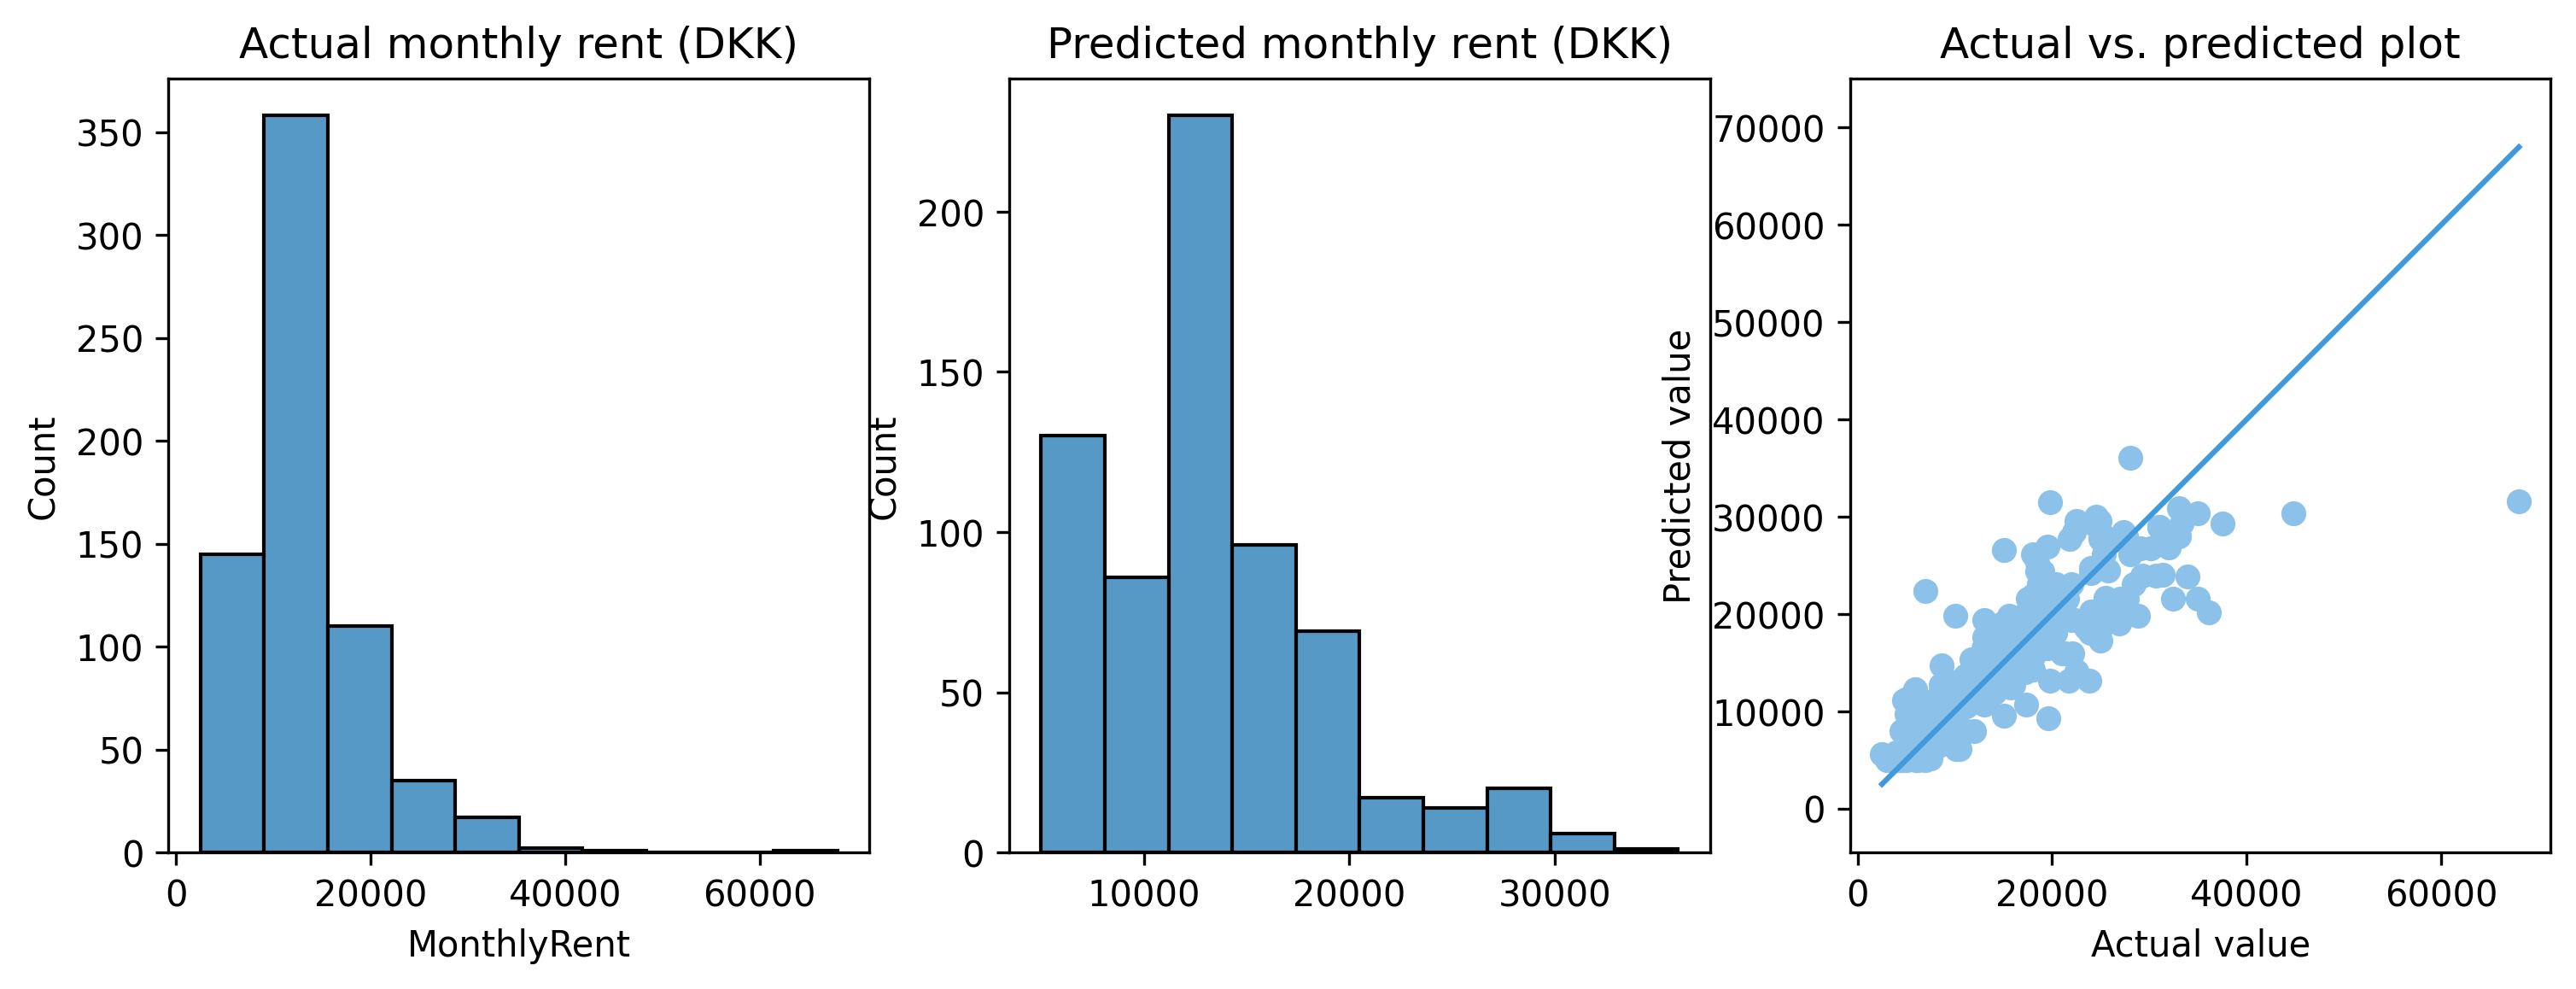

In [24]:
# Generating plots to evaluate the model's performance
GenModelFitPlots(RandomForestPredictions, Y_Test, "monthly rent (DKK)")

### RF model with 10 predictive trees and max depth of 10

The first random forest model we're testing has the following distinctive parameters:
* Number of estimators (`n_estimators`) = 10
* Maximum depth (`max_depth`) = 10

In [25]:
# Model with 10 trees in the forest
RandomForest = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = RandomStateNumberModels)

# Fitting the model
Model = RandomForest.fit(X_Train, Y_Train)

# Making predictions
RandomForestPredictions = Model.predict(X_Test)

# Getting model fit stats
print("==================================")
print("Results from a random forest model")
print("==================================\n")
ModelFitStats(Model, Y_Test, RandomForestPredictions)

Results from a random forest model

--------------------
MODEL SUMMARY REPORT
--------------------

Outcome variable (Y): MonthlyRent 

Mean value of the outcome variable: 13419.19
Standard deviation of the outcome variable: 6439.21 

Mean value of the model's prediction: 13479.04
Standard deviation of the model's prediction: 5864.2 

-----------------
MODEL FIT METRICS
-----------------

R-squared of the model: 83.67 %
Mean absolute error for model (MAE): 1298.21
Mean squared error for model (MSE): 6772605.49
Root mean square error for model (RMSE): 2602.42
Mean actual value: 13419.19
Predictions deviating by 9.67 % from actual values based on MAE
Predictions deviating by 19.39 % from actual values based on RMSE


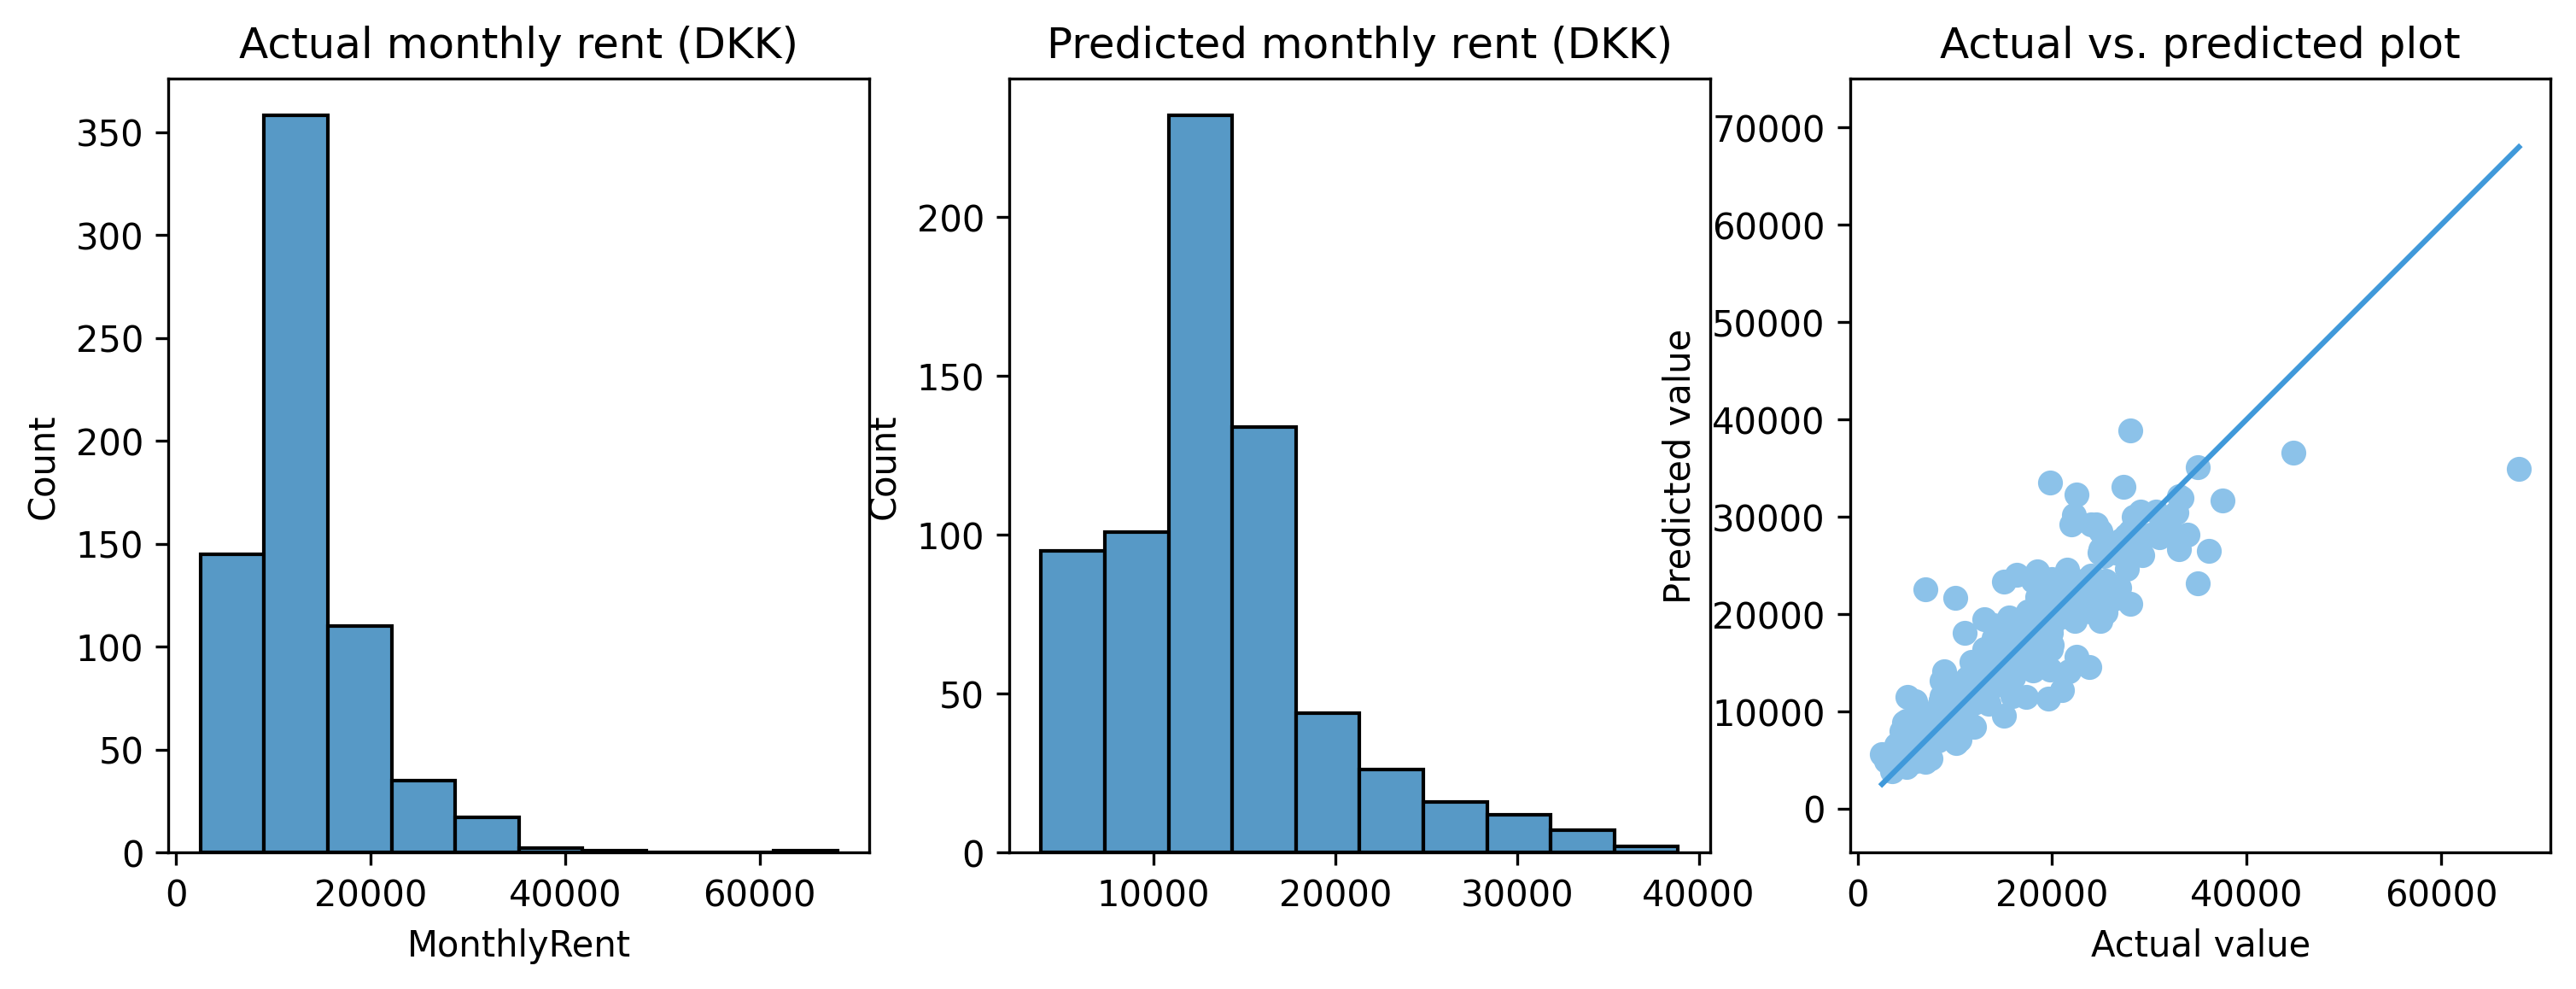

In [26]:
# Generating plots to evaluate the model's performance
GenModelFitPlots(RandomForestPredictions, Y_Test, "monthly rent (DKK)")

### RF model with 100 predictive trees and max depth of 10

The first random forest model we're testing has the following distinctive parameters:
* Number of estimators (`n_estimators`) = 100
* Maximum depth (`max_depth`) = 10

In [27]:
# Model with 100 trees in the forest
RandomForest = RandomForestRegressor(n_estimators = 100, max_depth = 10, random_state = RandomStateNumberModels)

# Fitting the model
Model = RandomForest.fit(X_Train, Y_Train)

# Making predictions
RandomForestPredictions = Model.predict(X_Test)

# Getting model fit stats
print("==================================")
print("Results from a random forest model")
print("==================================\n")
ModelFitStats(Model, Y_Test, RandomForestPredictions)

Results from a random forest model

--------------------
MODEL SUMMARY REPORT
--------------------

Outcome variable (Y): MonthlyRent 

Mean value of the outcome variable: 13419.19
Standard deviation of the outcome variable: 6439.21 

Mean value of the model's prediction: 13445.97
Standard deviation of the model's prediction: 5813.83 

-----------------
MODEL FIT METRICS
-----------------

R-squared of the model: 84.21 %
Mean absolute error for model (MAE): 1236.91
Mean squared error for model (MSE): 6545195.06
Root mean square error for model (RMSE): 2558.36
Mean actual value: 13419.19
Predictions deviating by 9.22 % from actual values based on MAE
Predictions deviating by 19.06 % from actual values based on RMSE


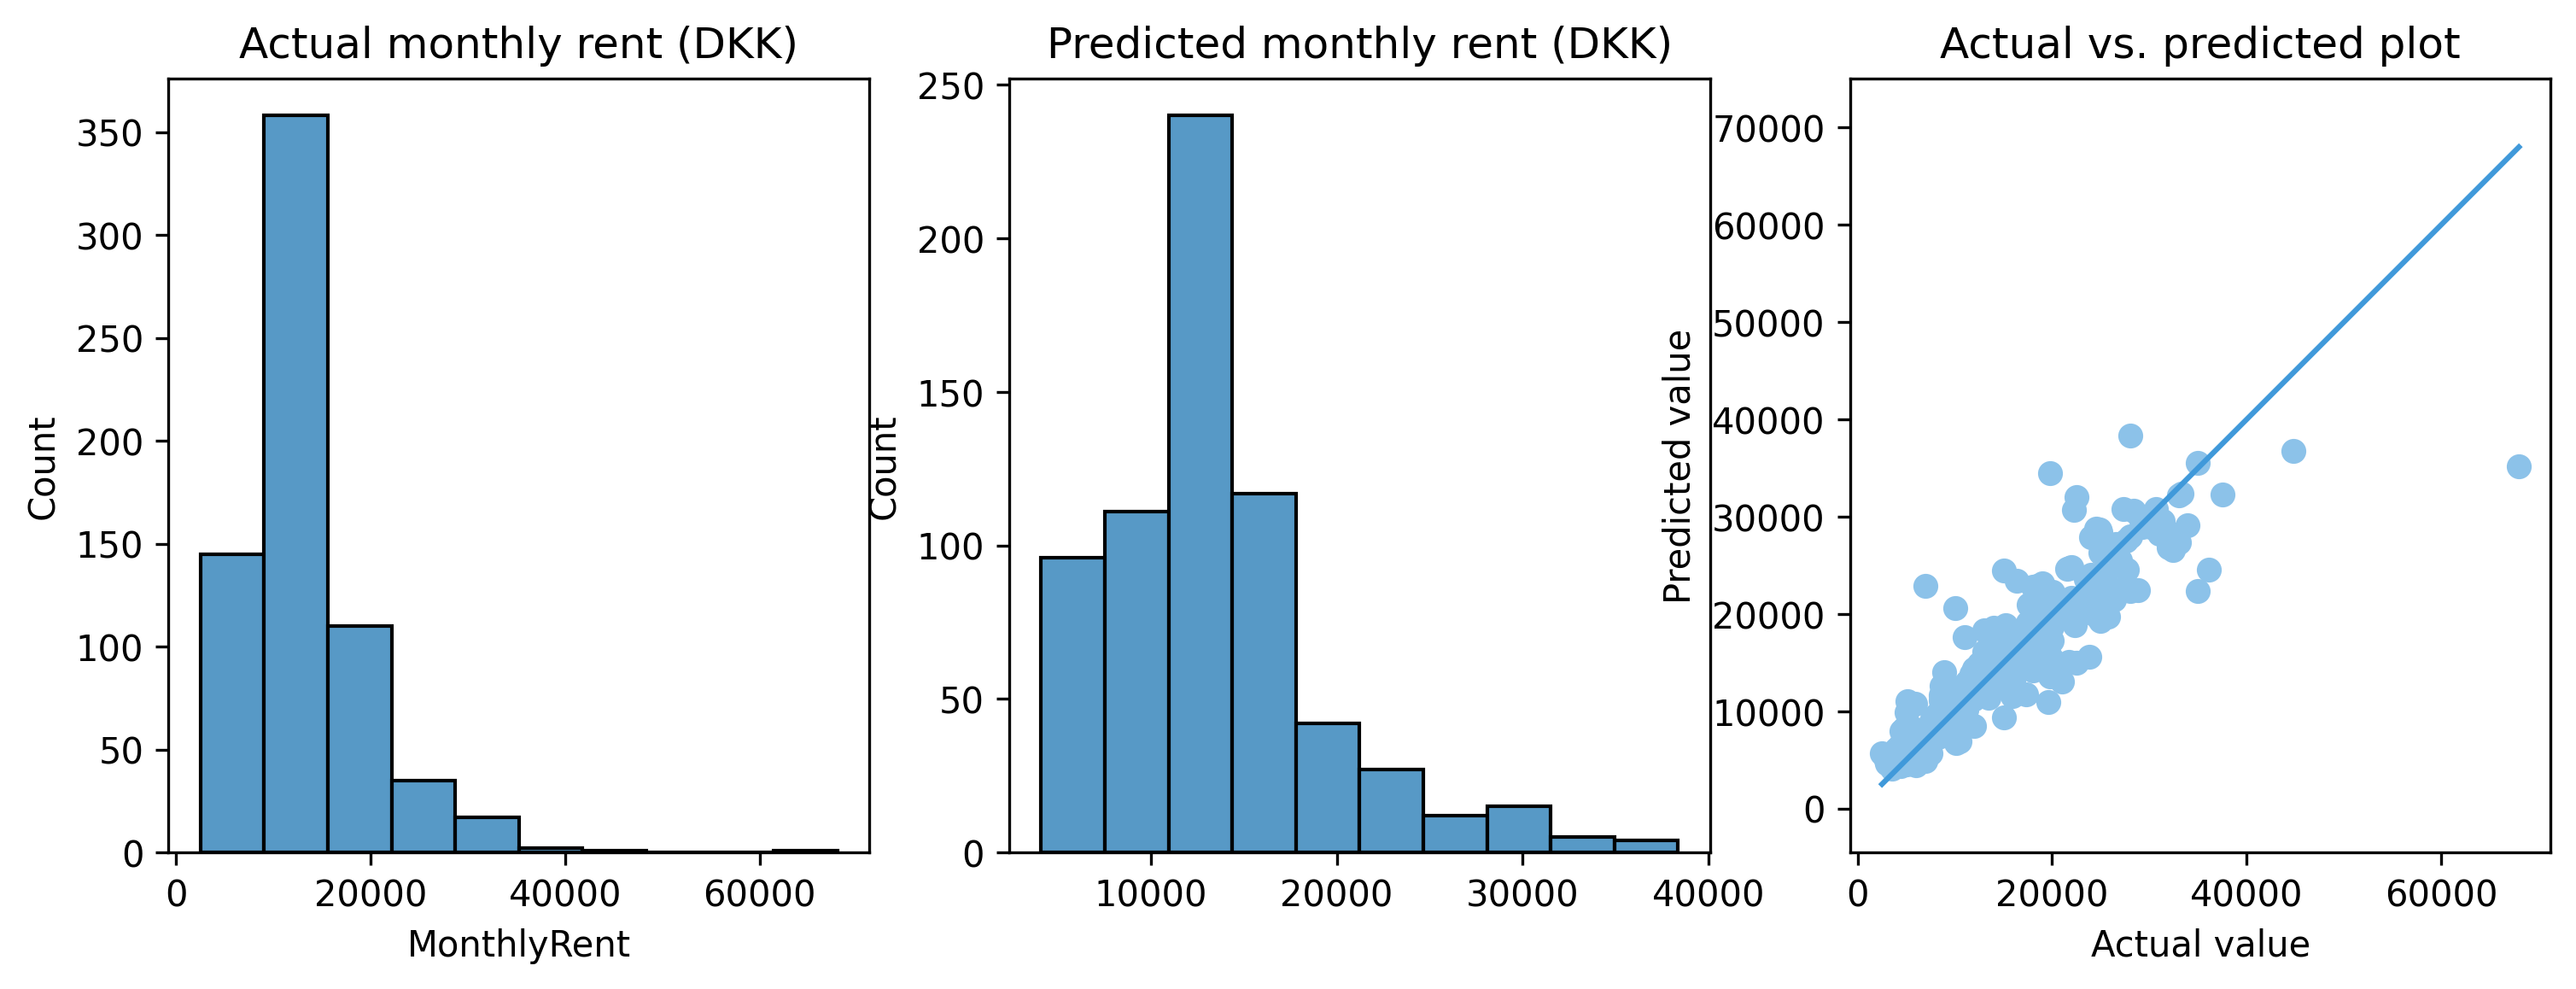

In [28]:
# Generating plots to evaluate the model's performance
GenModelFitPlots(RandomForestPredictions, Y_Test, "monthly rent (DKK)")

### RF model with 1,000 predictive trees and max depth of 15

The first random forest model we're testing has the following distinctive parameters:
* Number of estimators (`n_estimators`) = 1000
* Maximum depth (`max_depth`) = 15

In [29]:
# Model with 1000 trees in the forest
RandomForest = RandomForestRegressor(n_estimators = 1000, max_depth = 15, random_state = RandomStateNumberModels)

# Fitting the model
Model = RandomForest.fit(X_Train, Y_Train)

# Making predictions
RandomForestPredictions = Model.predict(X_Test)

# Getting model fit stats
print("==================================")
print("Results from a random forest model")
print("==================================\n")
ModelFitStats(Model, Y_Test, RandomForestPredictions)

Results from a random forest model

--------------------
MODEL SUMMARY REPORT
--------------------

Outcome variable (Y): MonthlyRent 

Mean value of the outcome variable: 13419.19
Standard deviation of the outcome variable: 6439.21 

Mean value of the model's prediction: 13465.72
Standard deviation of the model's prediction: 5851.72 

-----------------
MODEL FIT METRICS
-----------------

R-squared of the model: 84.42 %
Mean absolute error for model (MAE): 1199.37
Mean squared error for model (MSE): 6461625.3
Root mean square error for model (RMSE): 2541.97
Mean actual value: 13419.19
Predictions deviating by 8.94 % from actual values based on MAE
Predictions deviating by 18.94 % from actual values based on RMSE


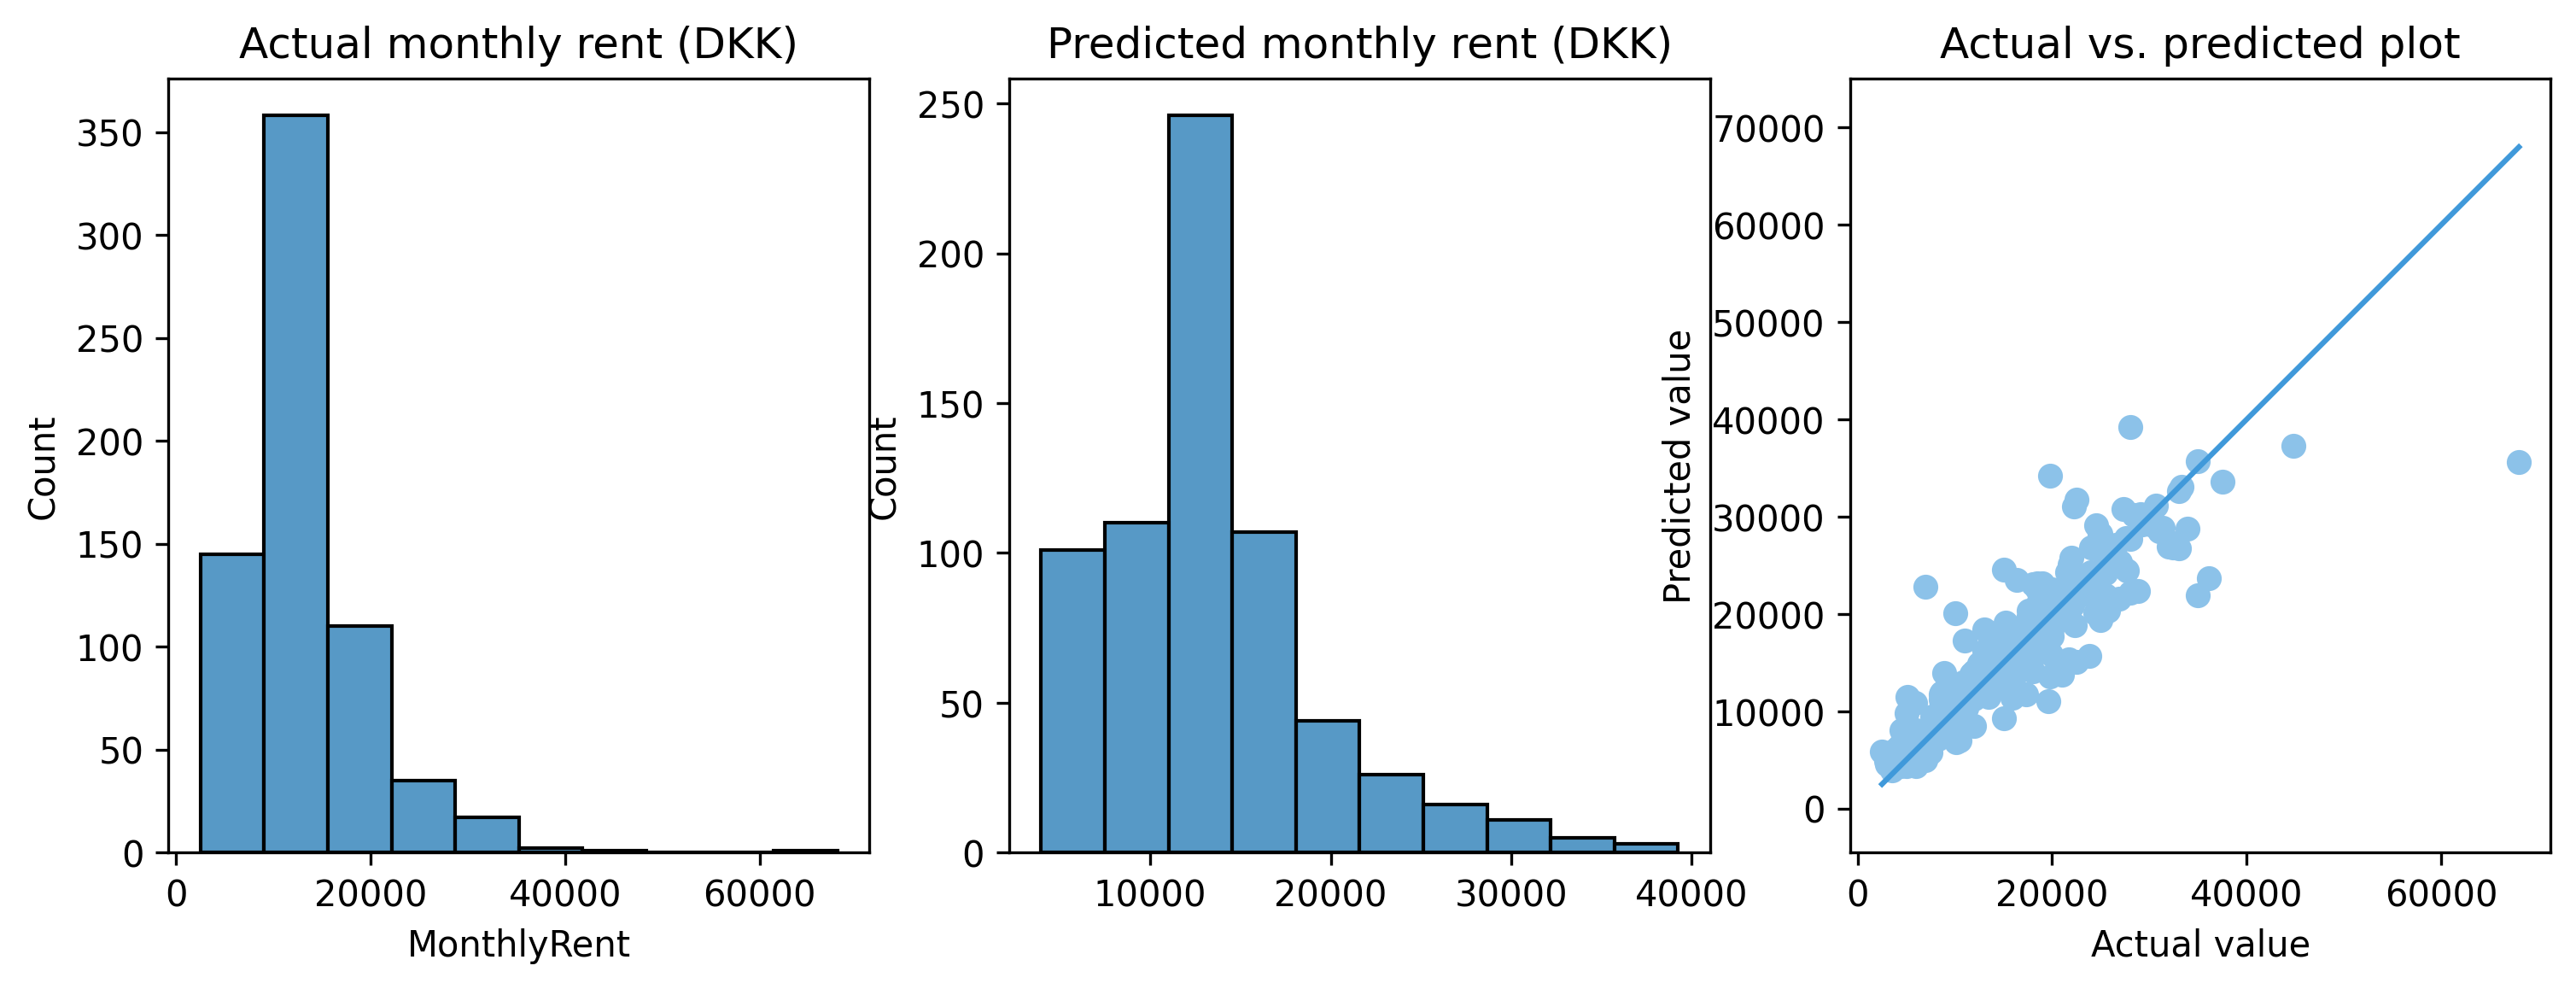

In [30]:
# Generating plots to evaluate the model's performance
GenModelFitPlots(RandomForestPredictions, Y_Test, "monthly rent (DKK)")

### Preliminary conclusions from manual tests of RF models

As the output generated above indicates, as we increase the number of trees in the RF model or the depth thereof, we see an improvement in its ability to predict monthly rent prices more accurately. However, there is a trade-off between computation power and the models' predictive ability that also needs to be taken into consideration before deciding on using a specific model.


### Automated tests of models with parameter hypertuning

Below, we use the `GridSearch` function in order to test multiple variations of the same model at the same time by making small changes to its parameters (the number of estimators/trees and the maximum depth). The purpose of this is to find the most optimal model parameters without having to manually tests many different iterations.

#### Testing the models

We're testing the following **alternative parameters**:

* `max_depth`: we choose between 5, 10, 15, 20 or 25 levels in our RF model
* `n_estimators`: we choose between having 10, 20, 50, 100, 500 or 1,000 trees in our RF model

In [31]:
# Preparing data for GridSearchCV
# This is to ensure we use the entirety of the data before GridSearchCV splits
# the data into a training and a test set
ColsToKeep = list(X_Train)
X_Grid = DataForModelling[ColsToKeep].copy()
Y_Grid = DataForModelling["MonthlyRent"].copy()

In [32]:
%%capture
# Defining which kind of sklearn model to use
regressor = RandomForestRegressor()

# Defining which parameters to vary in the process of optimization
grid = {
    "max_depth": [5, 10, 15, 20, 25],
    "n_estimators": [10, 20, 50, 100, 500, 1000]
}

# Defining stats to use to evaluate model fit
# For getting multiple scores to use in the output, refer to this page:
# https://scikit-learn.org/stable/modules/model_evaluation.html
StatsForModelFitEval = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error"]

# Preparing for running the series of models
grid_apply = GridSearchCV(regressor, grid, scoring = StatsForModelFitEval, cv = 5, refit = False, verbose = 2)

# Fitting the models
grid_apply.fit(X_Grid, Y_Grid)

# Selecting parameters to preview and putting them into a dataframe
ParamsToPreview = ["param_n_estimators", "param_max_depth", "mean_test_r2", "mean_test_neg_mean_absolute_error", "mean_test_neg_root_mean_squared_error", "mean_fit_time"]
ModelTestResults = pd.DataFrame(grid_apply.cv_results_)
ModelTestResults = ModelTestResults[ParamsToPreview].copy()

# Giving the parameters more user-friendly names and converting the MAE/RMSE into a positive number
ModelTestResults.columns = ["NumberOfEstimators", "MaxDepth", "MeanTest_R2", "MeanTest_RMSE", "MeanTest_MAE", "MeanFitTime_Seconds"]
ModelTestResults["MeanTest_RMSE"] = np.abs(ModelTestResults["MeanTest_RMSE"])
ModelTestResults["MeanTest_MAE"] = np.abs(ModelTestResults["MeanTest_MAE"])

#### Ranking the models based on their fit

The results below show different **stats on model fit** (R², MAE and RMSE) that are obtained from 5 tests of each combination of the alternative parameters listed above. The table below includes the top 10 best performing models, which are selected based on an average ranking off the R², MAE and RMSE metrics:

In [33]:
# Creating individual ranking variables for each model stat
ModelTestResults.sort_values("MeanTest_R2", ascending = False, inplace = True)
ModelTestResults["Rank_R2"] = ModelTestResults.reset_index().index + 1
ModelTestResults.sort_values("MeanTest_MAE", ascending = True, inplace = True)
ModelTestResults["Rank_MAE"] = ModelTestResults.reset_index().index + 1
ModelTestResults.sort_values("MeanTest_RMSE", ascending = True, inplace = True)
ModelTestResults["Rank_RMSE"] = ModelTestResults.reset_index().index + 1

# Creating a combined average ranking based on all three metrics and sorting the data
ModelTestResults["Rank_Avg"] = (ModelTestResults["Rank_R2"] + ModelTestResults["Rank_MAE"] + ModelTestResults["Rank_RMSE"])/3
ModelTestResults.sort_values("Rank_Avg", ascending = True, inplace = True)
ModelTestResults.reset_index(inplace = True, drop = True)
ModelTestResults[0:10]

,NumberOfEstimators,MaxDepth,MeanTest_R2,MeanTest_RMSE,MeanTest_MAE,MeanFitTime_Seconds,Rank_R2,Rank_MAE,Rank_RMSE,Rank_Avg
0,500,20,0.806641,1516.943765,3030.408695,40.886204,2,2,3,2.333333
1,50,20,0.807156,1532.090489,3023.588729,3.857229,1,1,10,4.000000
2,1000,15,0.805513,1523.956545,3037.490265,68.877554,4,3,7,4.666667
3,1000,25,0.805436,1523.620259,3038.784583,78.598595,5,4,6,5.000000
4,100,25,0.805552,1530.015595,3042.191372,8.142146,3,5,8,5.333333
5,500,15,0.804626,1522.939363,3045.376669,31.703129,7,6,5,6.000000
6,50,25,0.805264,1517.127648,3047.974997,4.152805,6,9,4,6.333333
7,100,20,0.804213,1514.926821,3051.339297,7.414759,9,10,2,7.000000
8,1000,20,0.804353,1530.809061,3046.481229,78.526118,8,7,9,8.000000
9,100,15,0.803996,1536.397893,3046.812787,6.137870,10,8,12,10.000000


#### Using the most optimal model to generate predictions

Below, we fit the model with the highest ranking and do a bit of interpretation of the results. The model wit the best fit is found automatically based on the metrics presented in the `ModelTestResults` table.

##### Evaluation of model fit metrics

The results of our automated tests showed that we don't necessarily have to have the most complex model: sticking with **500 estimators** and a **maximum depth of 20** was enough to provide us with the best all-round estimates for the model's fit metrics.

Specifically, the configuration selected allows us to explain about **R²=89.4%** of what's driving monthly rent prices and on average. At the same time, our predictions are between 7.4%-14.8% off the actual observed value of `MonthlyRent` on average (based on the **MAE** and **RMSE** respectively).

In [34]:
# Automatically detecting the model with the best fit
ModelTestResults["BestRanking"] = np.min(ModelTestResults["Rank_Avg"])
ModelTestResults["ModelHasBestRanking"] = (ModelTestResults["Rank_Avg"] == ModelTestResults["BestRanking"])

# Getting the relevant parameters from the model with the best fit
BestFit = ModelTestResults[ModelTestResults["ModelHasBestRanking"] == True].copy()
BestFit_N_Estimators = ModelTestResults["NumberOfEstimators"][0]
BestFit_MaxDepth = ModelTestResults["MaxDepth"][0]

# Defining the kind of model to test based on the automatically sourced parameters
RandomForest = RandomForestRegressor(n_estimators = BestFit_N_Estimators, max_depth = BestFit_MaxDepth, random_state = RandomStateNumberModels)
print("The model tested below has the following parameters:")
print("Number of estimators:", BestFit_N_Estimators)
print("Maximum depth:", BestFit_MaxDepth, "\n")

# Fitting the model
Model = RandomForest.fit(X_Train, Y_Train)

# Making predictions
RandomForestPredictions = Model.predict(X_Test)

# Getting model fit stats
print("==================================")
print("Results from a random forest model")
print("==================================\n")
ModelFitStats(Model, Y_Test, RandomForestPredictions)

The model tested below has the following parameters:
Number of estimators: 500
Maximum depth: 20 

Results from a random forest model

--------------------
MODEL SUMMARY REPORT
--------------------

Outcome variable (Y): MonthlyRent 

Mean value of the outcome variable: 13419.19
Standard deviation of the outcome variable: 6439.21 

Mean value of the model's prediction: 13463.61
Standard deviation of the model's prediction: 5853.35 

-----------------
MODEL FIT METRICS
-----------------

R-squared of the model: 84.25 %
Mean absolute error for model (MAE): 1202.78
Mean squared error for model (MSE): 6532112.25
Root mean square error for model (RMSE): 2555.8
Mean actual value: 13419.19
Predictions deviating by 8.96 % from actual values based on MAE
Predictions deviating by 19.05 % from actual values based on RMSE


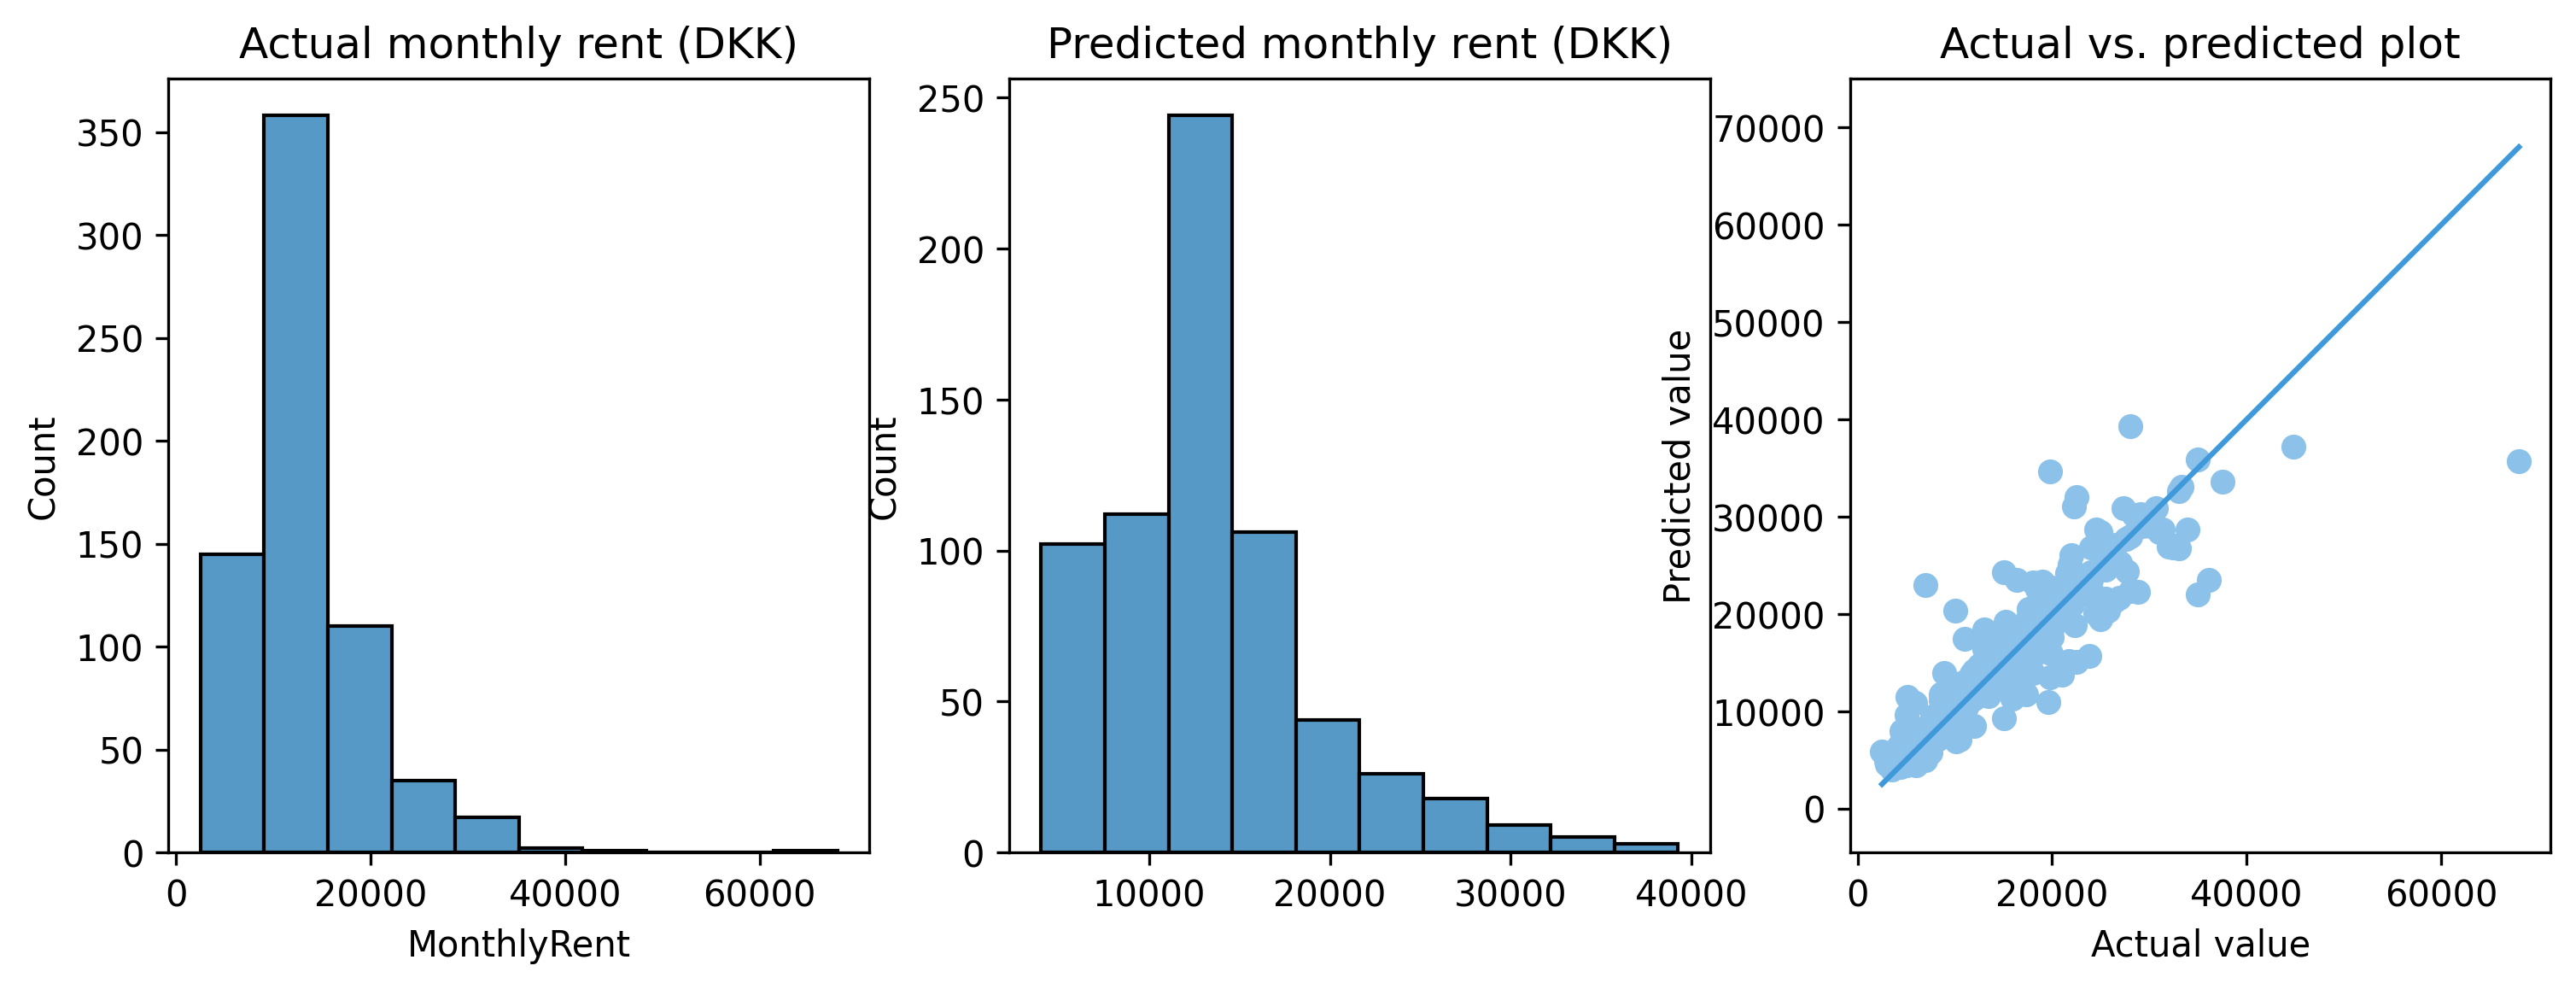

In [35]:
# Generating plots to evaluate the model's performance
GenModelFitPlots(RandomForestPredictions, Y_Test, "monthly rent (DKK)")

#### Bonus: trade-off between model performance and resource use

Below, we plot the metrics we use to evaluate model fit (R², MAE and RMSE) up against the amount of time it takes to fit the various models that we tested automatically.

As it can be seen from all charts, there is a **clear trade-off** between how well the model performs and how many resources it needs for the model to be fit. Although there are some outliers on the scatter plot, the following conclusions emerge:

* Arriving at a model with a higher R² is associated with a generally longer time to fit the model (as expected).
* Arriving at a model with a lower RMSE is associated with a generally longer time to fit the model (as expected).
* Arriving at a model with a lower MAE is associated with a generally longer time to fit the model (as expected).

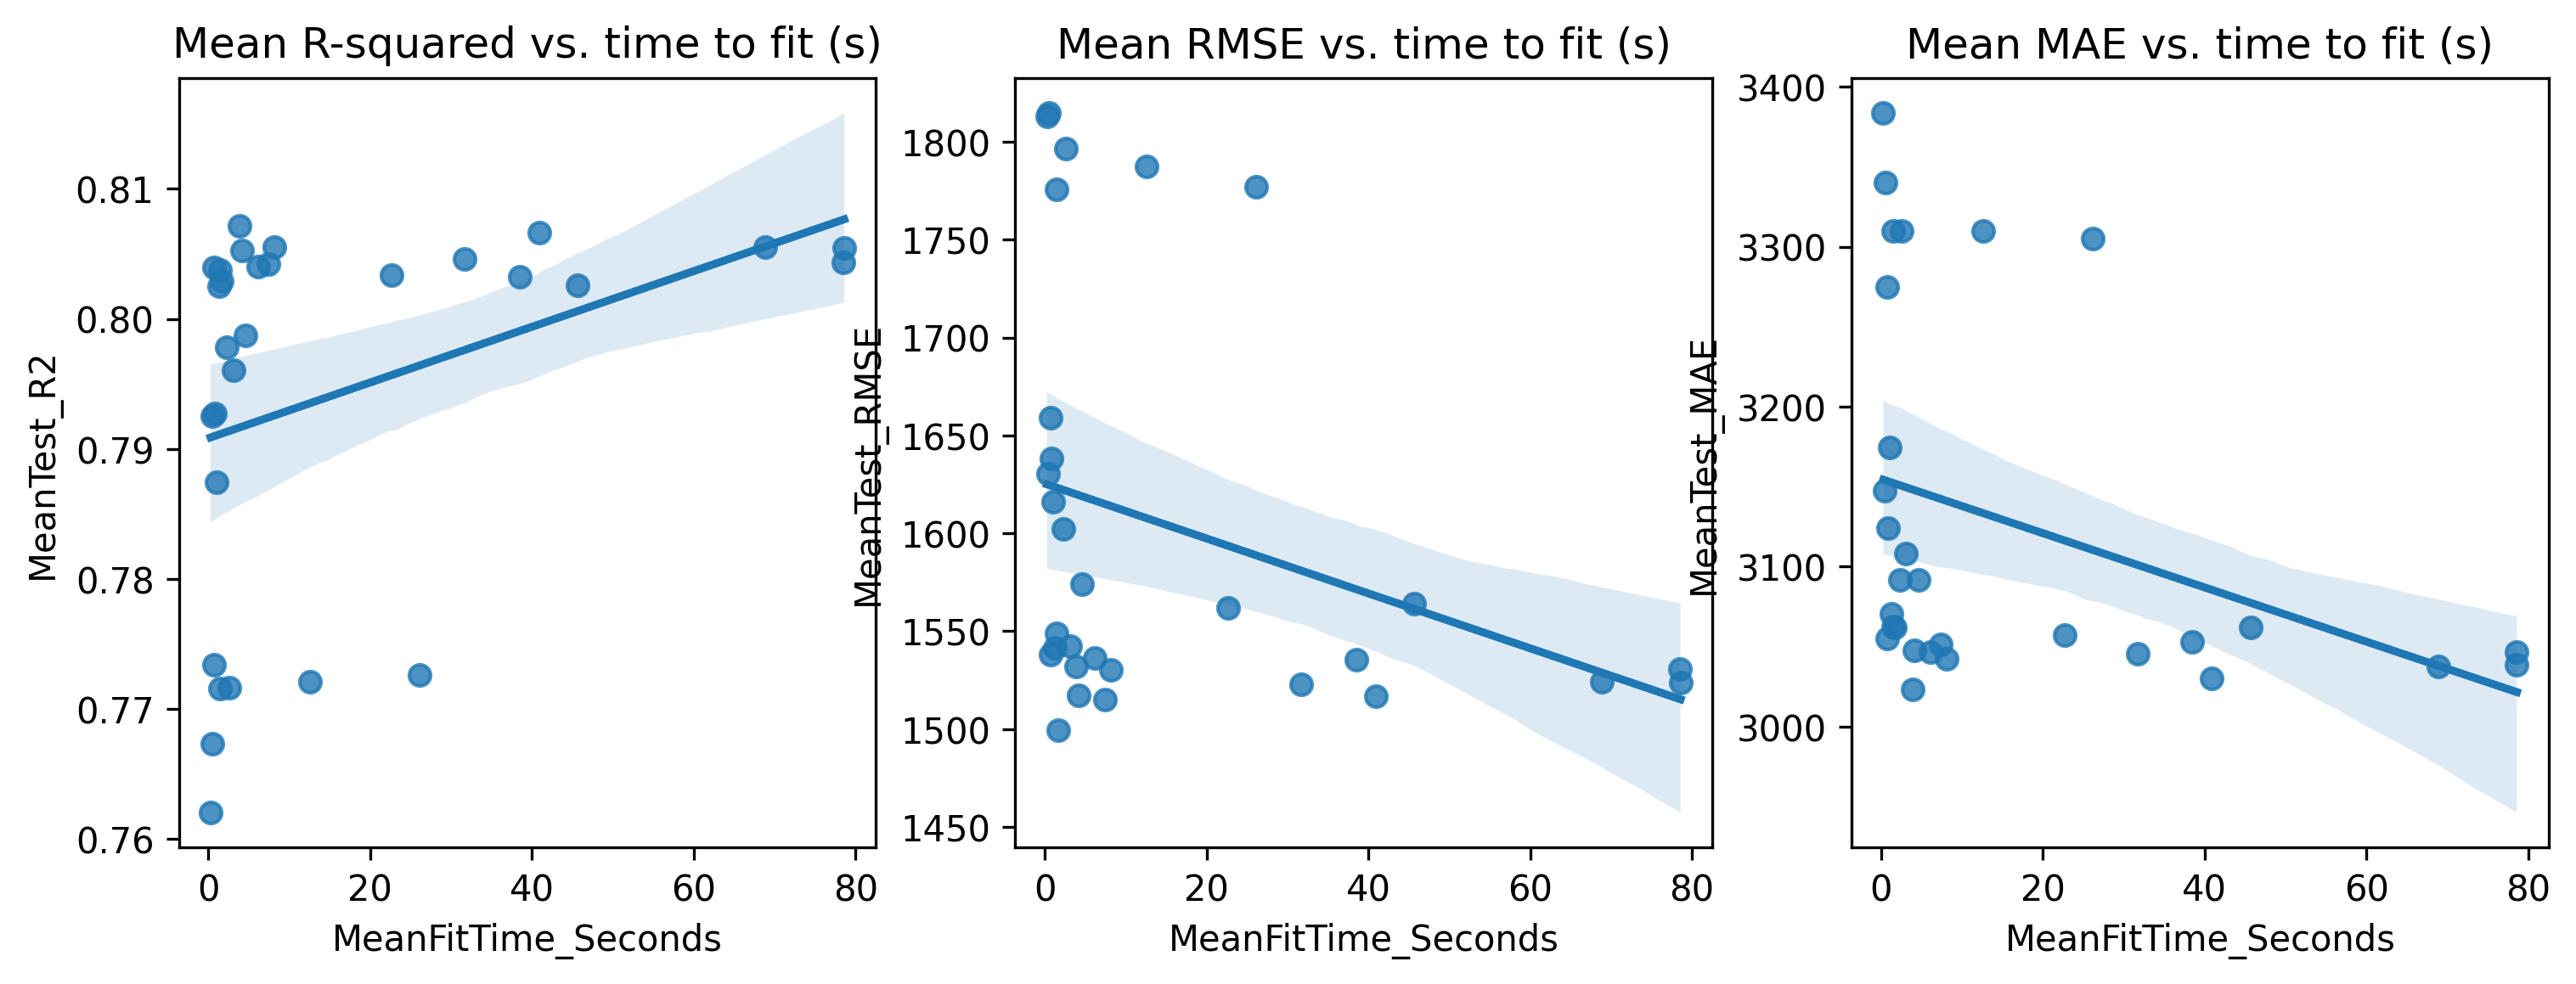

In [36]:
# Creating 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize = (12, 4))

# Plotting the key model fit stats up against the amount of time taken to fit the models
sns.regplot(x = ModelTestResults["MeanFitTime_Seconds"], y = ModelTestResults["MeanTest_R2"], ax = axes[0])
sns.regplot(x = ModelTestResults["MeanFitTime_Seconds"], y = ModelTestResults["MeanTest_RMSE"], ax = axes[1])
sns.regplot(x = ModelTestResults["MeanFitTime_Seconds"], y = ModelTestResults["MeanTest_MAE"], ax = axes[2])

# Customizing the titles displayed on the plot
axes[0].title.set_text("Mean R-squared vs. time to fit (s)")
axes[1].title.set_text("Mean RMSE vs. time to fit (s)")
axes[2].title.set_text("Mean MAE vs. time to fit (s)")
plt.show()

## Part 2: Tests of random forest models

In **Part 2** of this notebook, we expand the dataset which we use for generating predictions with additional variables in an attempt to improve the predictive power of our model.

Once again, we do a manual test to allow us to compare its results to the results of the previous models we tested manually.

**Overall, the purpose of having this 2nd part** is to see whether the inclusion of additional information in the model is a more or a less effective method of improving the model's predictive power than simply attempting to fine-tune its parameters.

### Adding data on economic conditions within the municipalities

In order to reflect the real market conditions, we are expanding the model to include a set of relevant economic indicators for the municipality in which the accommodations are located. This is also done with the purpose of improving the model's ability to create more accurate predictions.

This includes data on average income, average debt, the number of places for sale per resident, local tax rate etc. The data is collected from [this webpage](https://www.mikonomi.dk/blog/2018/05/%C3%B8konomiske-forhold-kommuner#resultater_kommuner) and a short preview is shown below (the preview may contain data on municipalities outside the Greater Copenhagen region):

In [37]:
# Importing economic data on municipalities and keeping relevant cols only
MunicipalEconomy = pd.read_excel(AnalysisFolder + "Data/Municipalities economic data.xlsx")
MunicipalEconomy.drop(columns = ["Region", "Source", "LastUpdated", "AvgRent"], inplace = True)

# Showing a preview to the user
MunicipalEconomy.head(5)

,Municipality,AverageIncome,SquareMeterPrice,PlacesForSalePerResident,LocalTaxRate,BasicDebt,UnemploymentRate,Debt,PensionSavings
0,Albertslund,280298,23254,0.0022,0.3660,0.02430,0.1464,512357,799594
1,Allerød,404423,25079,0.0057,0.3703,0.02280,0.0715,1355995,1610017
2,Assens,283827,9492,0.0157,0.3920,0.02212,0.1049,922040,859732
3,Ballerup,317890,26410,0.0036,0.3837,0.02889,0.1015,652182,960877
4,Billund,302269,11906,0.0100,0.3704,0.01848,0.0702,886739,900409


In [38]:
# Adding economic data to accommodations data
Accommodations = pd.merge(Accommodations, MunicipalEconomy, how = "left", on = "Municipality")
Accommodations.drop_duplicates(subset = ["Link"], inplace = True)

### Preparing data for modelling

Before we proceed with running any further tests, we generate new X and Y training and testing sets that we can feed into our models.

In [39]:
# Generating Y and X training and test sets based on custom inputs
PrepareDataForModelling(Accommodations, "MonthlyRent", 0.25, RandomStateNumberModels, 0.89, VarsToRemove = ["Link"])

Number of observations (missing values included): 3036
Number of observations (missing values excluded): 2366 

Outcome variable (Y): MonthlyRent
Model features (X): Index(['StreetName', 'PostCode', 'TownOrCity', 'Municipality', 'Latitude',
       'Longitude', 'BalconyOrTerrace', 'AccommodationType', 'BikeParking',
       'SuitableForSharing',
       ...
       'NearestTrainStation_Åmarken', 'NearestTrainStation_Østerport',
       'AverageIncome', 'SquareMeterPrice', 'PlacesForSalePerResident',
       'LocalTaxRate', 'BasicDebt', 'UnemploymentRate', 'Debt',
       'PensionSavings'],
      dtype='object', length=1201) 

Number of observations in training data: 1774
Number of observations in test data: 592


### RF model with 5 predictive trees and max depth of 5

The first random forest model we're testing has the following distinctive parameters:
* Number of estimators (`n_estimators`) = 5
* Maximum depth (`max_depth`) = 5

In [40]:
# Model with 5 trees in the forest
RandomForest = RandomForestRegressor(n_estimators = 5, max_depth = 5, random_state = RandomStateNumberModels)

# Fitting the model
Model = RandomForest.fit(X_Train, Y_Train)

# Making predictions
RandomForestPredictions = Model.predict(X_Test)

# Getting model fit stats
print("==================================")
print("Results from a random forest model")
print("==================================\n")
ModelFitStats(Model, Y_Test, RandomForestPredictions)

Results from a random forest model

--------------------
MODEL SUMMARY REPORT
--------------------

Outcome variable (Y): MonthlyRent 

Mean value of the outcome variable: 14476.6
Standard deviation of the outcome variable: 6859.31 

Mean value of the model's prediction: 14508.51
Standard deviation of the model's prediction: 6187.62 

-----------------
MODEL FIT METRICS
-----------------

R-squared of the model: 83.03 %
Mean absolute error for model (MAE): 1721.68
Mean squared error for model (MSE): 7982326.73
Root mean square error for model (RMSE): 2825.3
Mean actual value: 14476.6
Predictions deviating by 11.89 % from actual values based on MAE
Predictions deviating by 19.52 % from actual values based on RMSE


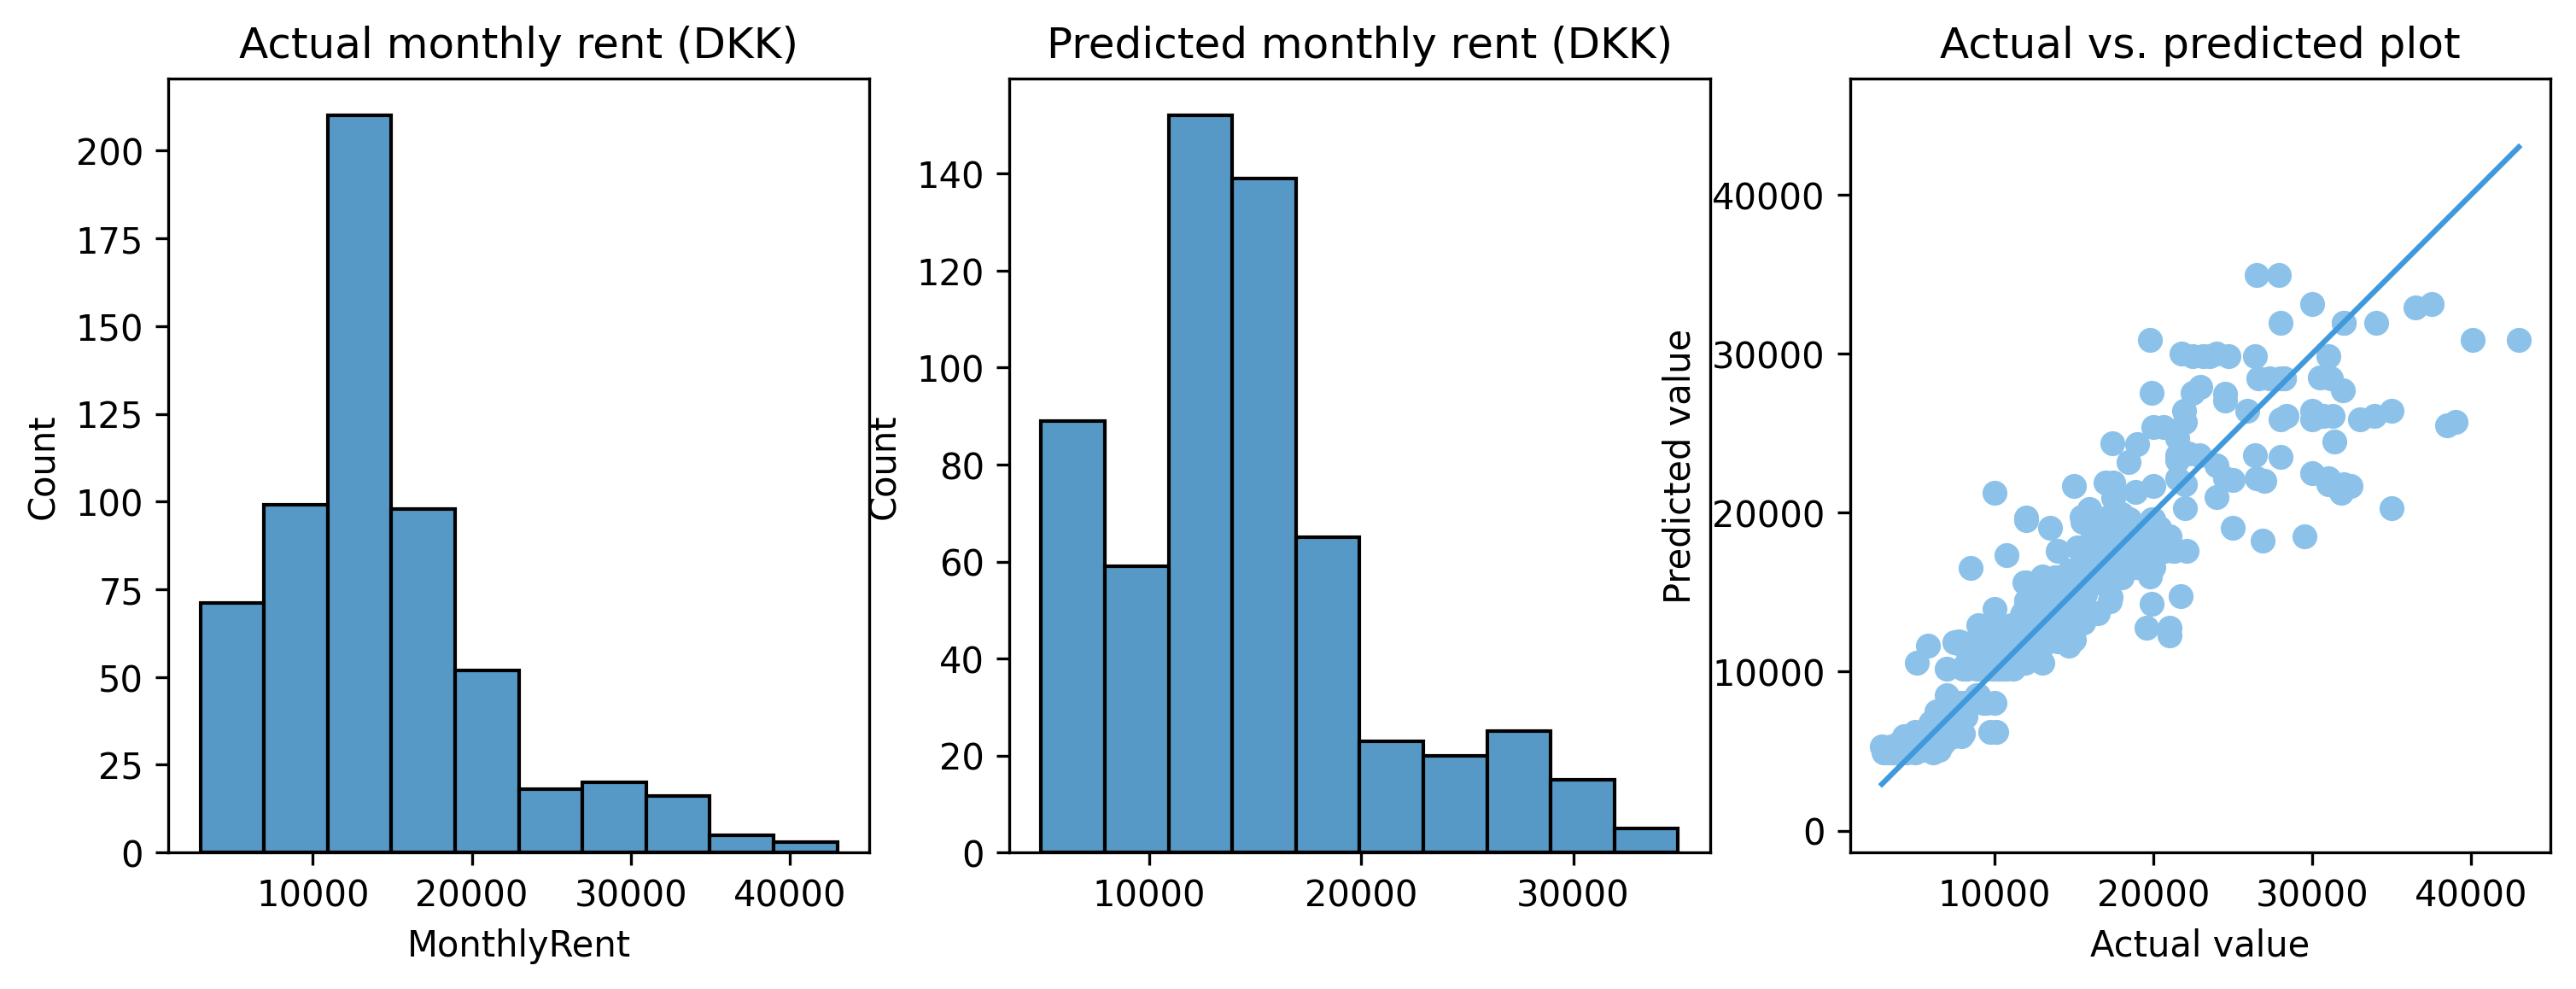

In [41]:
# Generating plots to evaluate the model's performance
GenModelFitPlots(RandomForestPredictions, Y_Test, "monthly rent (DKK)")

### RF model with 1,000 predictive trees and max depth of 15

The first random forest model we're testing has the following distinctive parameters:
* Number of estimators (`n_estimators`) = 1000
* Maximum depth (`max_depth`) = 15

In [42]:
# Model with 1000 trees in the forest
RandomForest = RandomForestRegressor(n_estimators = 1000, max_depth = 15, random_state = RandomStateNumberModels)

# Fitting the model
Model = RandomForest.fit(X_Train, Y_Train)

# Making predictions
RandomForestPredictions = Model.predict(X_Test)

# Getting model fit stats
print("==================================")
print("Results from a random forest model")
print("==================================\n")
ModelFitStats(Model, Y_Test, RandomForestPredictions)

Results from a random forest model

--------------------
MODEL SUMMARY REPORT
--------------------

Outcome variable (Y): MonthlyRent 

Mean value of the outcome variable: 14476.6
Standard deviation of the outcome variable: 6859.31 

Mean value of the model's prediction: 14582.1
Standard deviation of the model's prediction: 6533.61 

-----------------
MODEL FIT METRICS
-----------------

R-squared of the model: 88.05 %
Mean absolute error for model (MAE): 1330.71
Mean squared error for model (MSE): 5623965.39
Root mean square error for model (RMSE): 2371.49
Mean actual value: 14476.6
Predictions deviating by 9.19 % from actual values based on MAE
Predictions deviating by 16.38 % from actual values based on RMSE


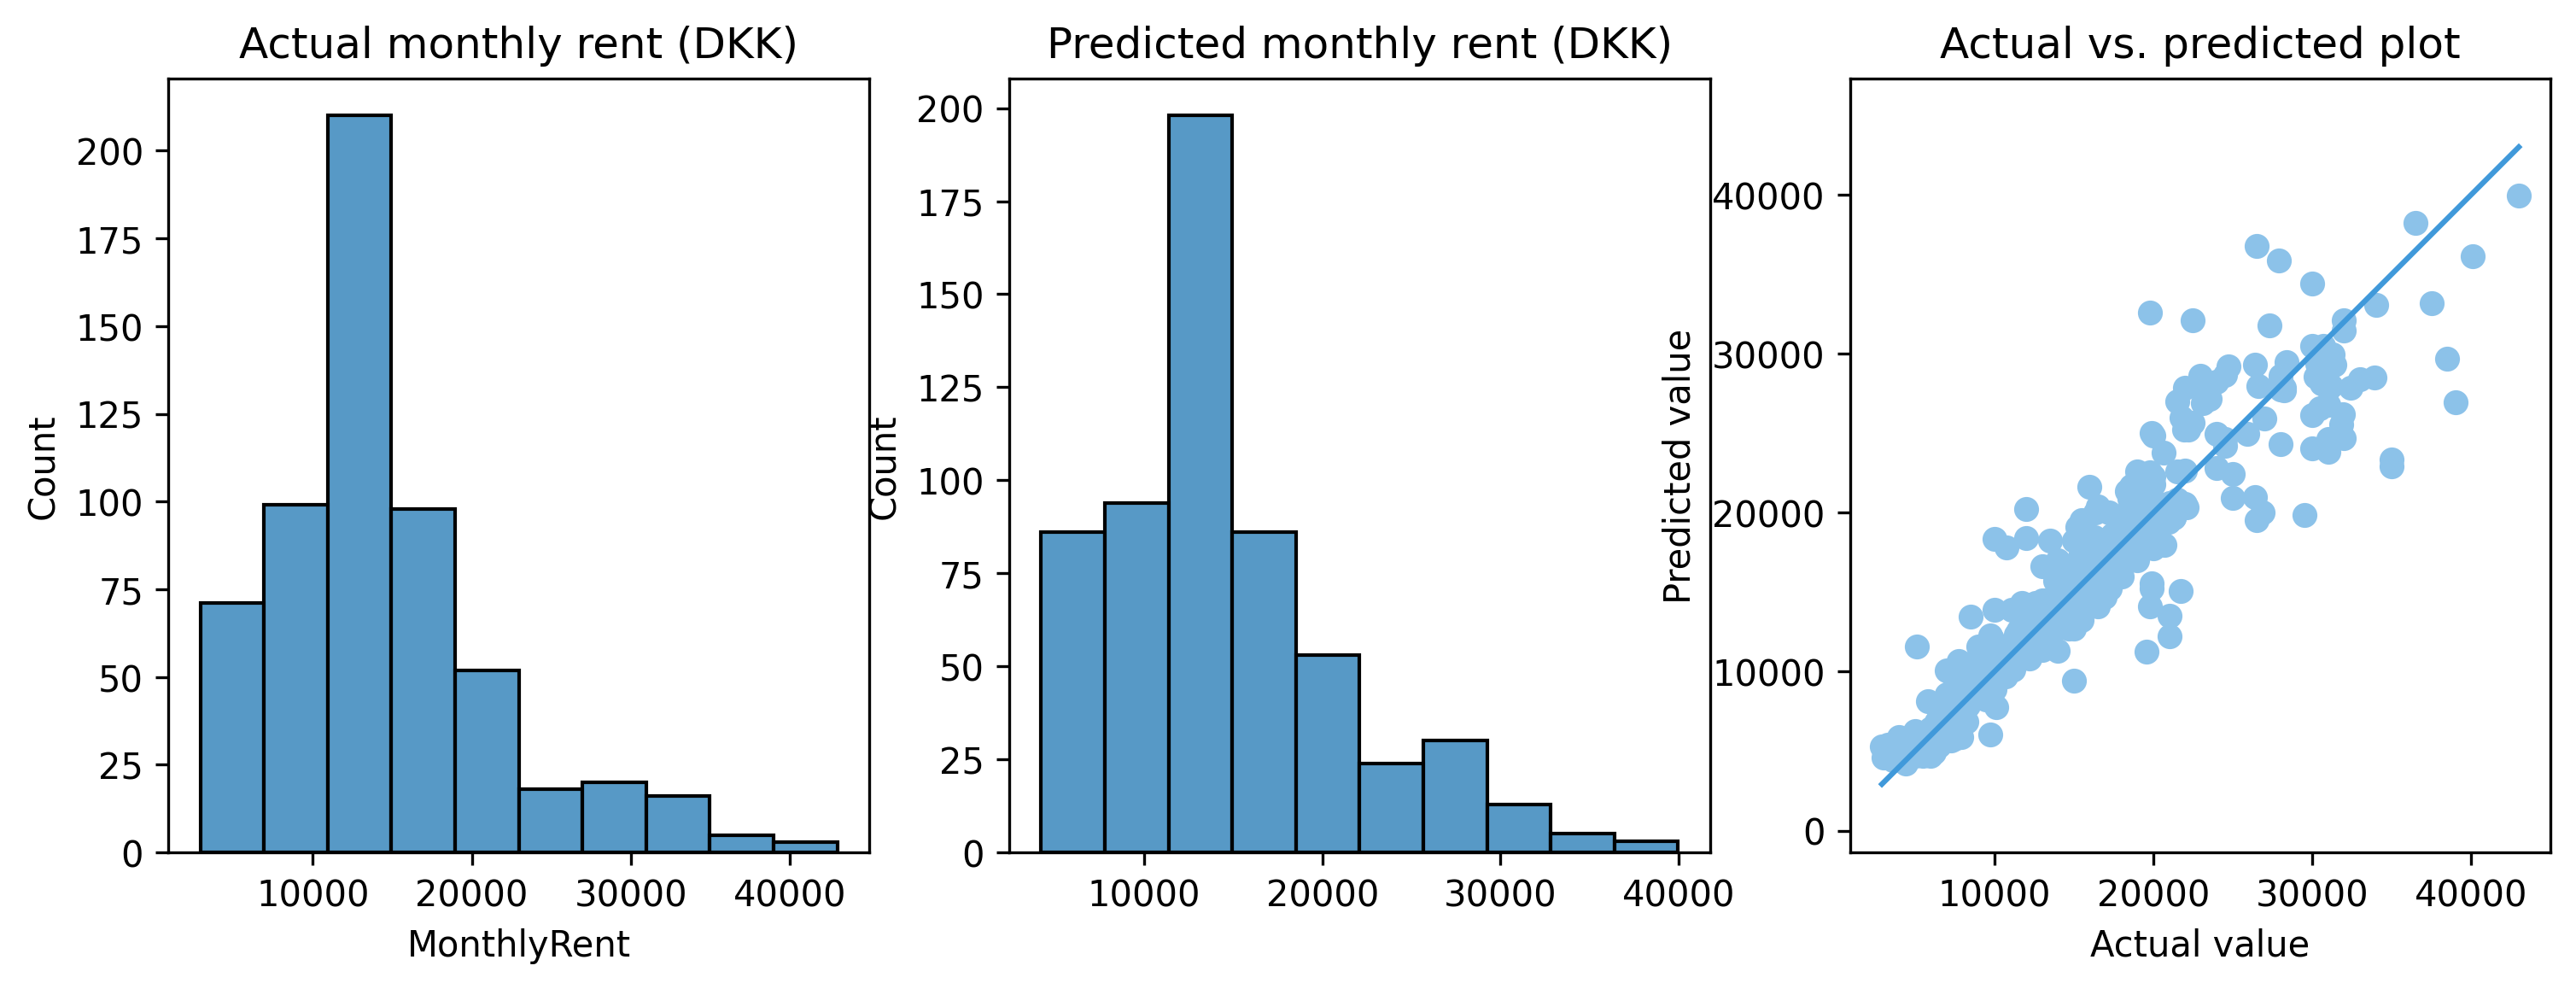

In [43]:
# Generating plots to evaluate the model's performance
GenModelFitPlots(RandomForestPredictions, Y_Test, "monthly rent (DKK)")

### Automated tests of models with parameter hypertuning

Below, we use the `GridSearch` function in order to test multiple variations of the same model at the same time by making small changes to its parameters (the number of estimators/trees and the maximum depth). The purpose of this is to find the most optimal model parameters without having to manually tests many different iterations.

#### Testing the models

We're testing the following **alternative parameters**:

* `max_depth`: we choose between 5, 10, 15, 20 or 25 levels in our RF model
* `n_estimators`: we choose between having 10, 20, 50, 100, 500 or 1,000 trees in our RF model

In [44]:
# Preparing data for GridSearchCV
# This is to ensure we use the entirety of the data before GridSearchCV splits
# the data into a training and a test set
ColsToKeep = list(X_Train)
X_Grid = DataForModelling[ColsToKeep].copy()
Y_Grid = DataForModelling["MonthlyRent"].copy()

In [45]:
%%capture
# Defining which kind of sklearn model to use
regressor = RandomForestRegressor()

# Defining which parameters to vary in the process of optimization
grid = {
    "max_depth": [5, 10, 15, 20, 25],
    "n_estimators": [10, 20, 50, 100, 500, 1000]
}

# Defining stats to use to evaluate model fit
# For getting multiple scores to use in the output, refer to this page:
# https://scikit-learn.org/stable/modules/model_evaluation.html
StatsForModelFitEval = ["r2", "neg_mean_squared_error", "neg_mean_absolute_error", "neg_root_mean_squared_error"]

# Preparing for running the series of models
grid_apply = GridSearchCV(regressor, grid, scoring = StatsForModelFitEval, cv = 5, refit = False, verbose = 2)

# Fitting the models
grid_apply.fit(X_Grid, Y_Grid)

# Selecting parameters to preview and putting them into a dataframe
ParamsToPreview = ["param_n_estimators", "param_max_depth", "mean_test_r2", "mean_test_neg_mean_absolute_error", "mean_test_neg_root_mean_squared_error", "mean_fit_time"]
ModelTestResults = pd.DataFrame(grid_apply.cv_results_)
ModelTestResults = ModelTestResults[ParamsToPreview].copy()

# Giving the parameters more user-friendly names and converting the MAE/RMSE into a positive number
ModelTestResults.columns = ["NumberOfEstimators", "MaxDepth", "MeanTest_R2", "MeanTest_RMSE", "MeanTest_MAE", "MeanFitTime_Seconds"]
ModelTestResults["MeanTest_RMSE"] = np.abs(ModelTestResults["MeanTest_RMSE"])
ModelTestResults["MeanTest_MAE"] = np.abs(ModelTestResults["MeanTest_MAE"])

#### Ranking the models based on their fit

The results below show different **stats on model fit** (R², MAE and RMSE) that are obtained from 5 tests of each combination of the alternative parameters listed above. The table below includes the top 10 best performing models, which are selected based on an average ranking off the R², MAE and RMSE metrics:

In [46]:
# Creating individual ranking variables for each model stat
ModelTestResults.sort_values("MeanTest_R2", ascending = False, inplace = True)
ModelTestResults["Rank_R2"] = ModelTestResults.reset_index().index + 1
ModelTestResults.sort_values("MeanTest_MAE", ascending = True, inplace = True)
ModelTestResults["Rank_MAE"] = ModelTestResults.reset_index().index + 1
ModelTestResults.sort_values("MeanTest_RMSE", ascending = True, inplace = True)
ModelTestResults["Rank_RMSE"] = ModelTestResults.reset_index().index + 1

# Creating a combined average ranking based on all three metrics and sorting the data
ModelTestResults["Rank_Avg"] = (ModelTestResults["Rank_R2"] + ModelTestResults["Rank_MAE"] + ModelTestResults["Rank_RMSE"])/3
ModelTestResults.sort_values("Rank_Avg", ascending = True, inplace = True)
ModelTestResults.reset_index(inplace = True, drop = True)
ModelTestResults[0:10]

,NumberOfEstimators,MaxDepth,MeanTest_R2,MeanTest_RMSE,MeanTest_MAE,MeanFitTime_Seconds,Rank_R2,Rank_MAE,Rank_RMSE,Rank_Avg
0,50,10,0.679515,2169.347812,3789.930301,2.244130,2,1,4,2.333333
1,10,15,0.684807,2153.781779,3814.105435,0.868906,1,4,3,2.666667
2,50,20,0.671651,2152.023573,3833.673452,3.325598,3,9,2,4.666667
3,500,10,0.669754,2197.475575,3808.066317,23.449546,5,2,9,5.333333
4,500,15,0.667531,2186.170619,3813.013527,31.942720,9,3,7,6.333333
5,500,25,0.666946,2177.539373,3816.261759,34.618672,10,5,5,6.666667
6,1000,20,0.667600,2184.228624,3820.438847,67.533783,8,6,6,6.666667
7,10,20,0.667950,2131.819400,3859.238637,1.057136,7,15,1,7.666667
8,1000,15,0.666745,2190.846314,3820.726204,62.648239,11,7,8,8.666667
9,10,25,0.669910,2251.193614,3825.757162,0.649608,4,8,22,11.333333


#### Using the most optimal model to generate predictions

Below, we fit the model with the highest ranking and do a bit of interpretation of the results. The model wit the best fit is found automatically based on the metrics presented in the `ModelTestResults` table.

##### Evaluation of model fit metrics

The results of our automated tests showed that we don't necessarily have to have the most complex model: sticking with **100 estimators** and a **maximum depth of 25** was enough to provide us with the best all-round estimates for the model's fit metrics.

Specifically, the configuration selected allows us to explain about **R²=91.1%** of what's driving monthly rent prices and on average. At the same time, our predictions are between 6.5%-12.6% off the actual observed value of `MonthlyRent` on average (based on the **MAE** and **RMSE** respectively).

##### Comparison to model containing fewer variables

Comparing this new model to some of the first models we tried where data on the local economic conditions in the municipalities was not included, we notice a couple of things:

* The gains in the model's R² and the reductions in the MAE and RMSE are higher when adding more variables relative to hypertuning the model's parameters
* Even with the addition of the new variables, there is still a portion of variance that remains unaccounted for, however, the model's accuracy can be considered sufficient for making predictions for the value of `MonthlyRent`

In [47]:
# Automatically detecting the model with the best fit
ModelTestResults["BestRanking"] = np.min(ModelTestResults["Rank_Avg"])
ModelTestResults["ModelHasBestRanking"] = (ModelTestResults["Rank_Avg"] == ModelTestResults["BestRanking"])

# Getting the relevant parameters from the model with the best fit
BestFit = ModelTestResults[ModelTestResults["ModelHasBestRanking"] == True].copy()
BestFit_N_Estimators = ModelTestResults["NumberOfEstimators"][0]
BestFit_MaxDepth = ModelTestResults["MaxDepth"][0]

# Defining the kind of model to test based on the automatically sourced parameters
RandomForest = RandomForestRegressor(n_estimators = BestFit_N_Estimators, max_depth = BestFit_MaxDepth, random_state = RandomStateNumberModels)
print("The model tested below has the following parameters:")
print("Number of estimators:", BestFit_N_Estimators)
print("Maximum depth:", BestFit_MaxDepth, "\n")

# Fitting the model
Model = RandomForest.fit(X_Train, Y_Train)

# Making predictions
RandomForestPredictions = Model.predict(X_Test)

# Getting model fit stats
print("==================================")
print("Results from a random forest model")
print("==================================\n")
ModelFitStats(Model, Y_Test, RandomForestPredictions)

The model tested below has the following parameters:
Number of estimators: 50
Maximum depth: 10 

Results from a random forest model

--------------------
MODEL SUMMARY REPORT
--------------------

Outcome variable (Y): MonthlyRent 

Mean value of the outcome variable: 14476.6
Standard deviation of the outcome variable: 6859.31 

Mean value of the model's prediction: 14601.7
Standard deviation of the model's prediction: 6545.65 

-----------------
MODEL FIT METRICS
-----------------

R-squared of the model: 87.93 %
Mean absolute error for model (MAE): 1355.6
Mean squared error for model (MSE): 5679901.1
Root mean square error for model (RMSE): 2383.25
Mean actual value: 14476.6
Predictions deviating by 9.36 % from actual values based on MAE
Predictions deviating by 16.46 % from actual values based on RMSE


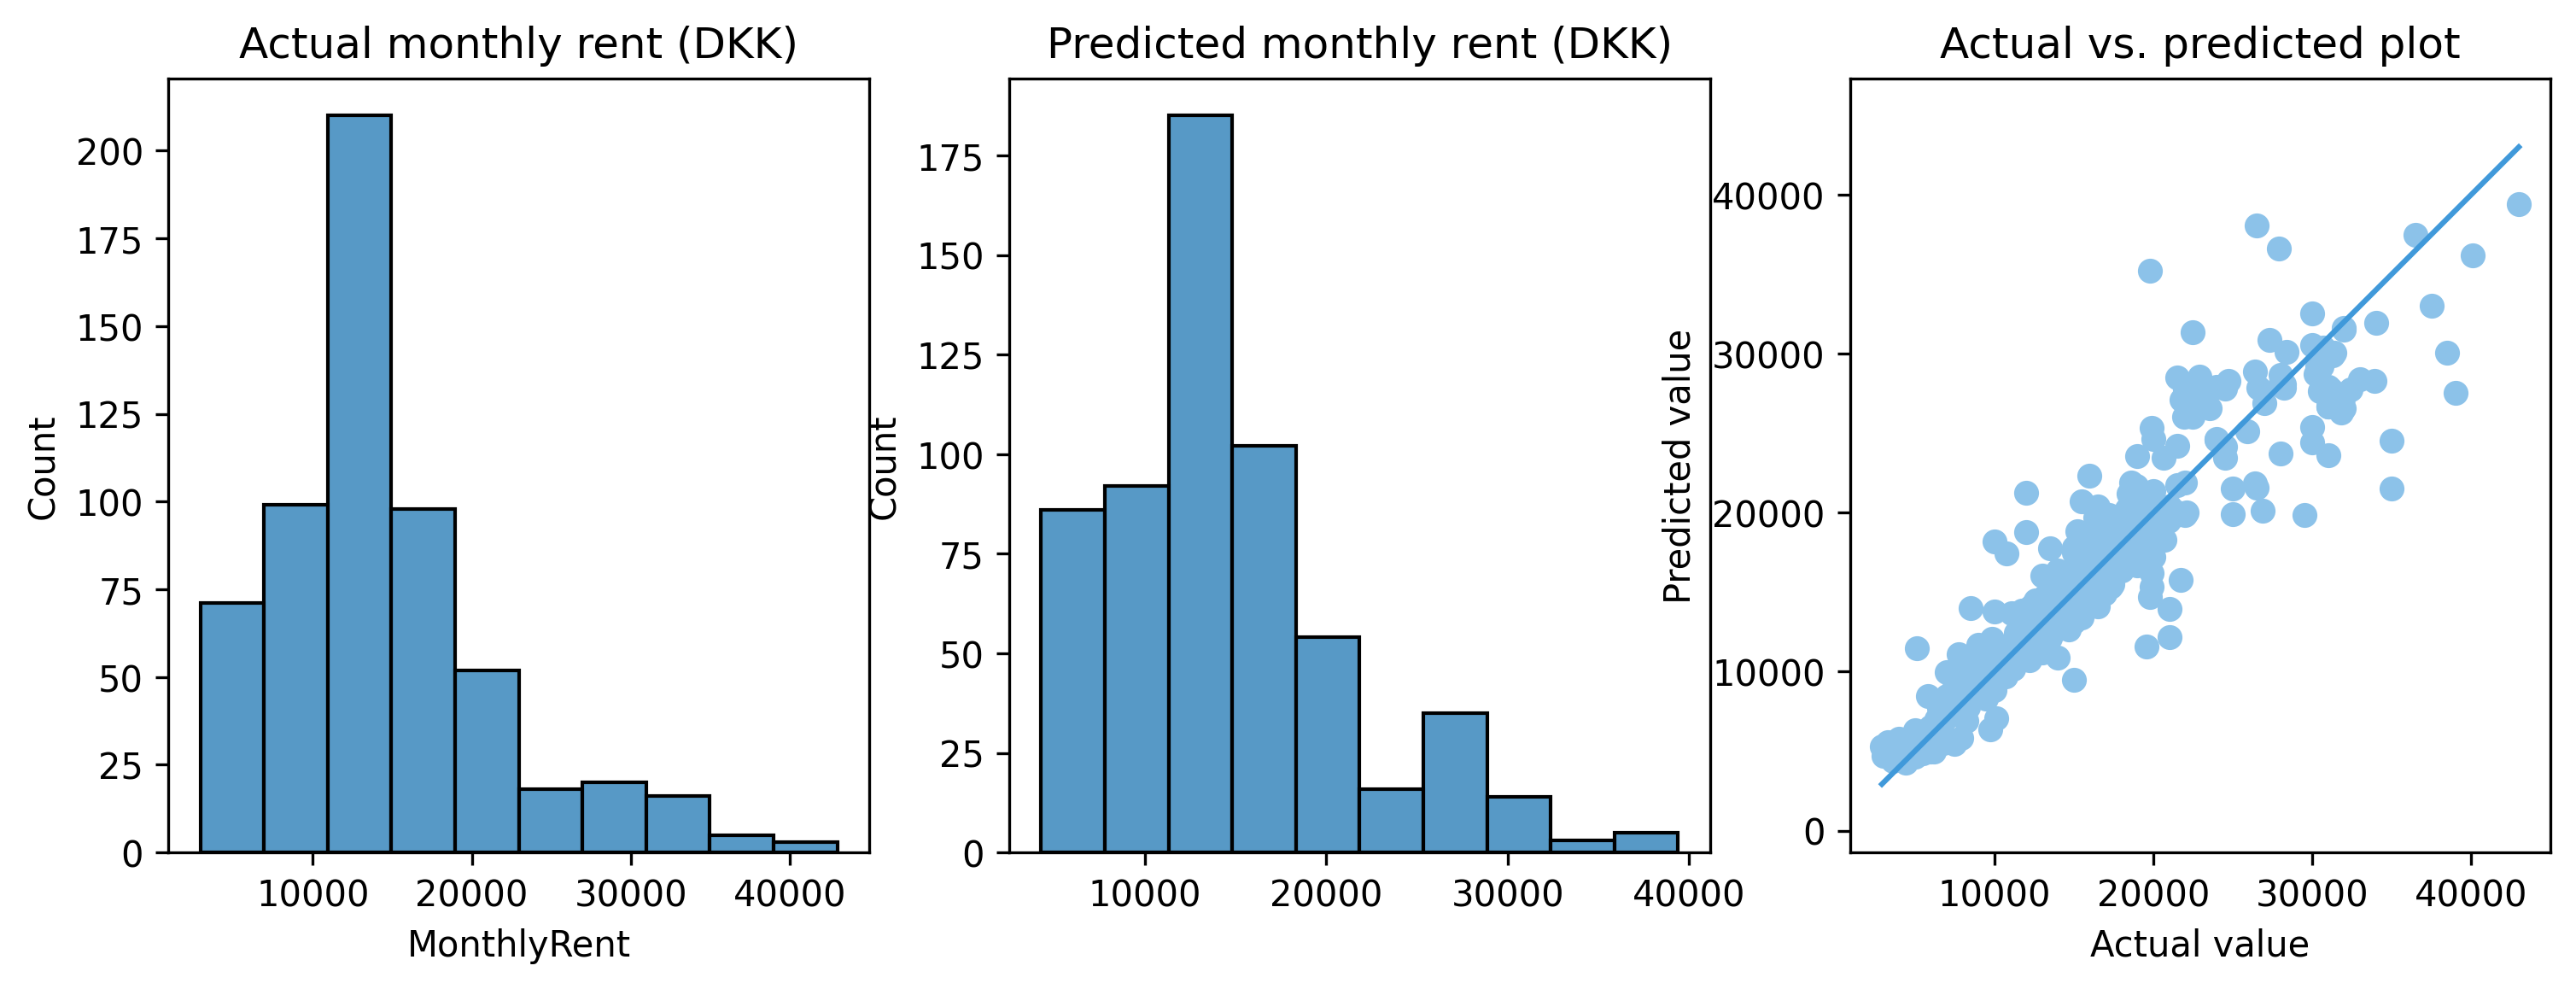

In [48]:
# Generating plots to evaluate the model's performance
GenModelFitPlots(RandomForestPredictions, Y_Test, "monthly rent (DKK)")

#### Bonus: trade-off between model performance and resource use

Below, we plot the metrics we use to evaluate model fit (R², MAE and RMSE) up against the amount of time it takes to fit the various models that we tested automatically.

As it can be seen from all charts, there is a **clear trade-off** between how well the model performs and how many resources it needs for the model to be fit. Although there are some outliers on the scatter plot, the following conclusions emerge:

* Arriving at a model with a higher R² is associated with a generally longer time to fit the model (as expected).
* Arriving at a model with a lower RMSE is associated with a generally longer time to fit the model (as expected).
* Arriving at a model with a lower MAE is associated with a generally longer time to fit the model (as expected).

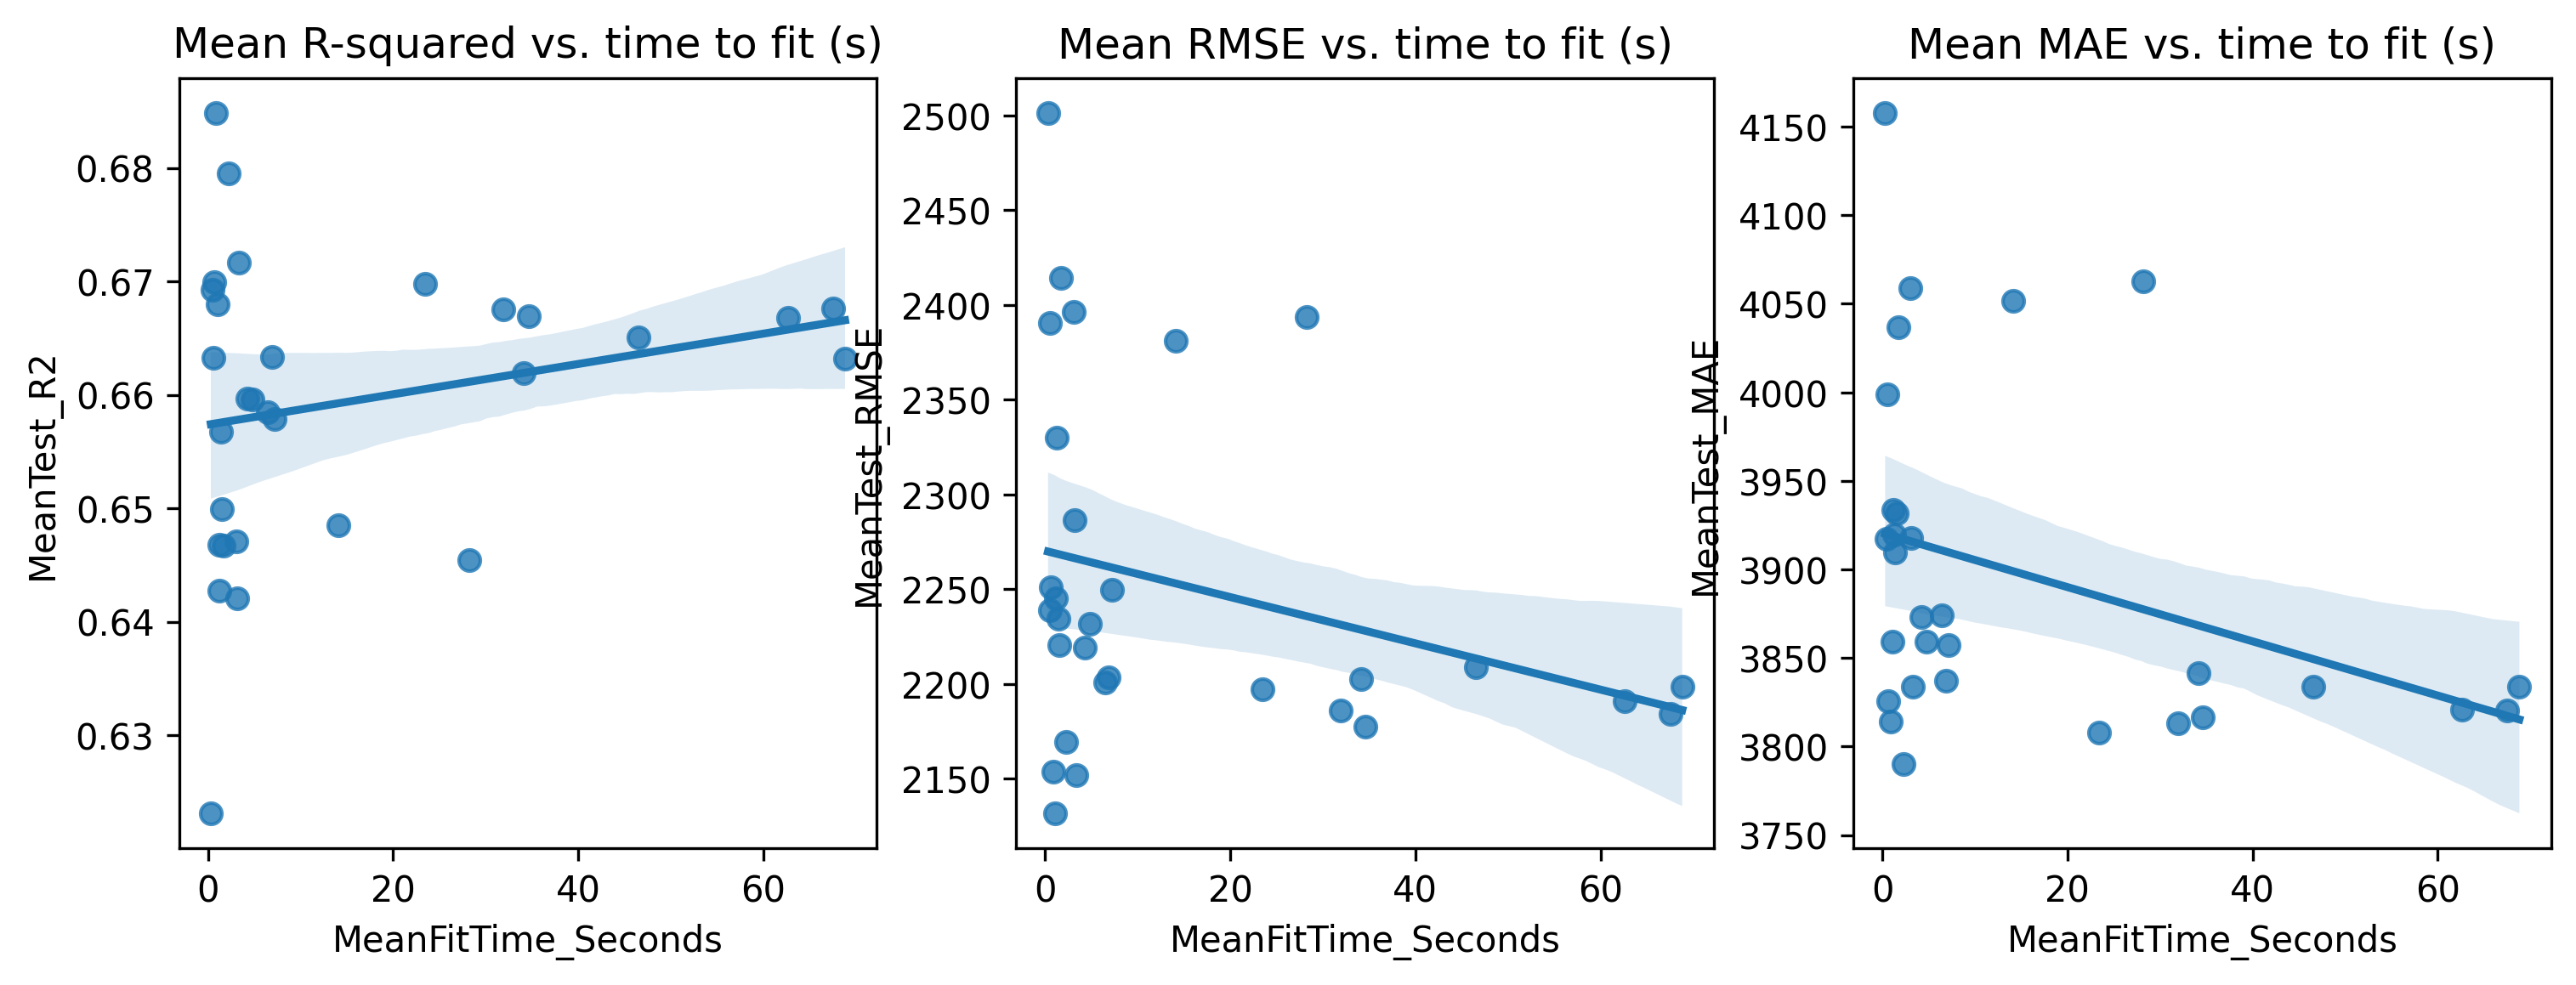

In [49]:
# Creating 3 side-by-side plots
fig, axes = plt.subplots(1, 3, figsize = (12, 4))

# Plotting the key model fit stats up against the amount of time taken to fit the models
sns.regplot(x = ModelTestResults["MeanFitTime_Seconds"], y = ModelTestResults["MeanTest_R2"], ax = axes[0])
sns.regplot(x = ModelTestResults["MeanFitTime_Seconds"], y = ModelTestResults["MeanTest_RMSE"], ax = axes[1])
sns.regplot(x = ModelTestResults["MeanFitTime_Seconds"], y = ModelTestResults["MeanTest_MAE"], ax = axes[2])

# Customizing the titles displayed on the plot
axes[0].title.set_text("Mean R-squared vs. time to fit (s)")
axes[1].title.set_text("Mean RMSE vs. time to fit (s)")
axes[2].title.set_text("Mean MAE vs. time to fit (s)")
plt.show()

#### Bonus: most important features

One of the cons of using a machine learning model like random forests (RF) is that it decreases interpretability (relative to a simpler model like e.g. linear regression). While that kind of model may be more suitable for generating predictions, it is also possible to get a basic understanding of the overall importance of the predictors for the outcome variable.

The figure below plots the top 10 most important features, i.e. the factors that explain the largest chunks of the variance of the `MonthlyRentBySqM` variable:

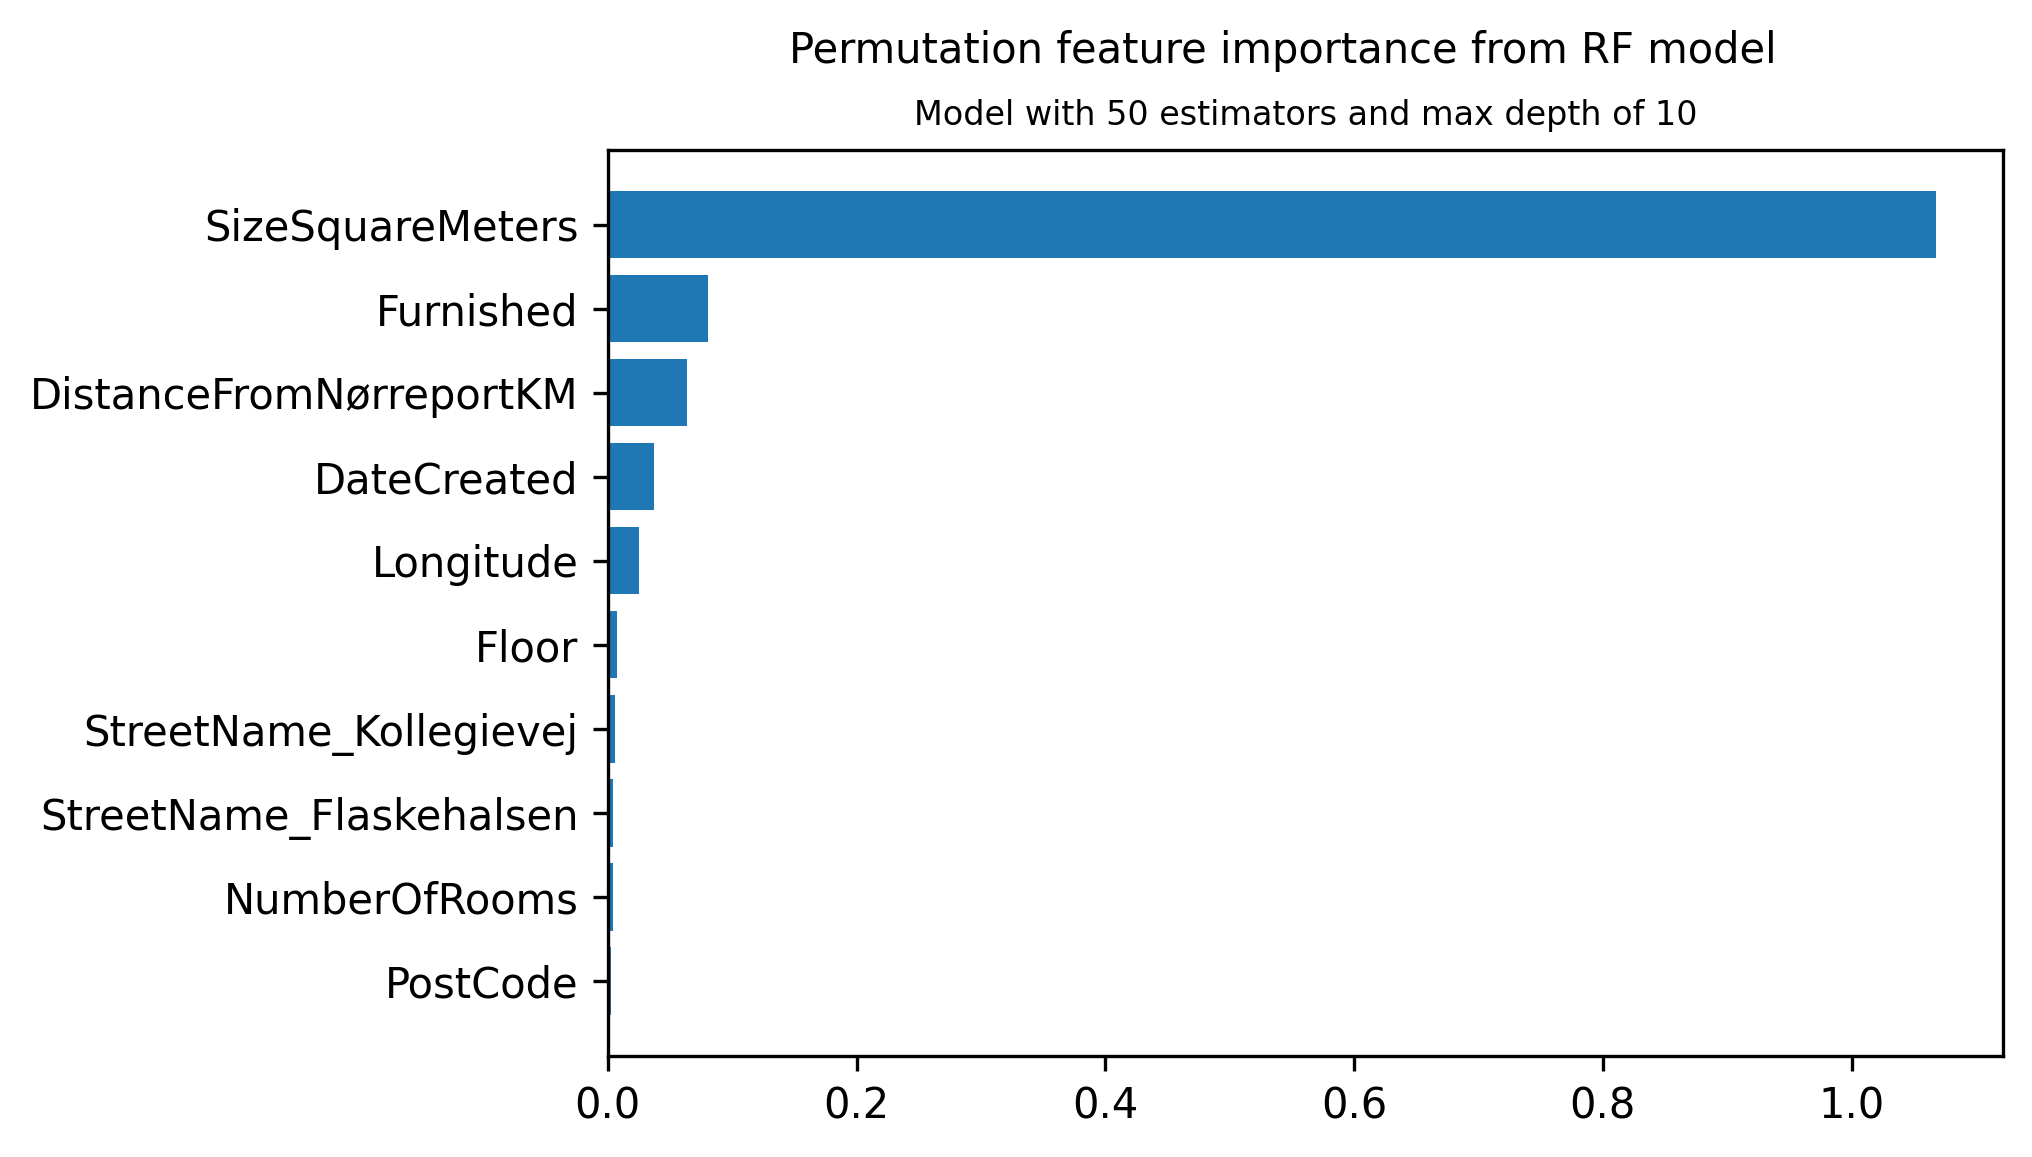

In [62]:
# Calculating permutation-based feature importance
perm_importance = permutation_importance(Model, X_Test, Y_Test)
sorted_idx = perm_importance.importances_mean.argsort()
FeaturesImportance = pd.DataFrame({"Feature":X_Train.columns[sorted_idx], "Importance":perm_importance.importances_mean[sorted_idx]})
FeaturesImportance.sort_values("Importance", ascending = False, inplace = True)
FeaturesImportance = FeaturesImportance[0:10].copy()
FeaturesImportance.sort_values("Importance", ascending = True, inplace = True)

# Plotting the feature importance on a chart
plt.barh(FeaturesImportance["Feature"], FeaturesImportance["Importance"])
plt.suptitle("Permutation feature importance from RF model", size = 10)
plt.title("Model with " + str(BestFit_N_Estimators) + " estimators and max depth of " + str(BestFit_MaxDepth), size = 8)
plt.show()

As the chart above suggests, the features with the highest importance for the monthly rent per square meter are the size of the accommodation, whether the latter is furnished or not, the floor on which it is located and its geographic location (in here, proxied by its distance from Nørreport). It seems like the west/east factor (longitude) is much more important than the north/south factor (latitude). The recency of the post is also among the top features in the model.